# GLIEDERUNG

- [Imports](#imports)
- [Kontext](#kontext)
- [Explorative Datenanalyse](#explorative-datenanalyse)
- [Unifying & Transformation](#unifying--transformation)
- [Data Cleansing](#data-cleansing)
  - [Prepare full Dataframe with wanted variables](#prepare-full-dataframe-with-wanted-variables)
  - [Merge Final Dataframe](#merge-final-dataframe)
- [Analysis & Validation](#analysis--validation)
- [Feature Selection & Engineering](#feature-selection--engineering)
  - [Binary encoding](#binary-encoding)
  - [Onehot encoding](#onehot-encoding)
  - [List the encodings (for application)](#list-the-encodings-for-application)
  - [Correlation Matrix](#correlation-matrix)
- [Anwendung in Machine Learning](#anwendung-in-machine-learning)
  - [Linear regression SGD](#linear-regression-sgd)
  - [XGBoost](#xgboost)
  - [Random Forest](#random-forest)
  - [Feedforward Network](#feedforward-network)
  - [Vergleich der Modelle](#vergleich-der-modelle)
- [Anwendung von XAI – Techniken](#anwendung-von-xai--techniken)
  - [SDG Regression](#sdg-regression)
  - [XGBoost](#xgboost-1)
  - [Random Forest](#random-forest-1)
  - [FNN](#fnn)



# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Kontext

https://ourworldindata.org/

# Explorative Datenanalyse

In [2]:
# Load the data files
file_path_female = 'data/remaining-life-expectancy-at-different-ages-females.csv'
file_path_male = 'data/remaining-life-expectancy-at-different-ages-males.csv'

female_data = pd.read_csv(file_path_female)
male_data = pd.read_csv(file_path_male)

### Create Dataframe Structure

In [3]:
# Extracting age columns and reshaping the female data
female_reshaped = female_data.melt(id_vars=['Entity', 'Year', 'Code'],
                                   var_name='Age', value_name='Remaining Life Expectancy')
female_reshaped['Sex'] = 'Female'

# Extracting age columns and reshaping the male data, including 'Code'
male_reshaped = male_data.melt(id_vars=['Entity', 'Year', 'Code'],
                               var_name='Age', value_name='Remaining Life Expectancy')
male_reshaped['Sex'] = 'Male'

# Concatenate the reshaped dataframes with 'Code'
combined_data = pd.concat([female_reshaped, male_reshaped])

# Extract the age from the 'Age' column
combined_data['Age'] = combined_data['Age'].str.extract(r'Age: (\d+)').astype(int)

# Reordering columns for clarity
combined_data = combined_data[['Entity', 'Code', 'Year', 'Sex', 'Age', 'Remaining Life Expectancy']]

combined_data.head()

,Entity,Code,Year,Sex,Age,Remaining Life Expectancy
0,Afghanistan,AFG,1950,Female,0,28.3905
1,Afghanistan,AFG,1951,Female,0,28.6345
2,Afghanistan,AFG,1952,Female,0,29.1260
3,Afghanistan,AFG,1953,Female,0,29.6212
4,Afghanistan,AFG,1954,Female,0,29.9004


In [4]:
combined_data.shape

(278908, 6)

In [5]:
combined_data.describe()

,Year,Age,Remaining Life Expectancy
count,278908.000000,278908.000000,278908.000000
mean,1978.822658,34.285714,38.468101
std,32.813750,27.701077,22.017019
min,1751.000000,0.000000,1.846400
25%,1963.000000,10.000000,15.169150
50%,1983.000000,25.000000,42.852350
75%,2002.000000,65.000000,56.466300
max,2021.000000,80.000000,88.727200


# Unifying & Transformation

Based on an looking at the different Datasets, we have decided to limit the data range to the years 2000 to 2020. This will help us manage the amount of missing data (NaN) more effectively.

In [6]:
# Filtering the data for years between 2000 and 2020, removing rows without a 'Code' variable, and excluding the 'World'
filtered_data = combined_data.dropna(subset=['Code'])
filtered_data = filtered_data[(filtered_data['Year'] >= 2000) & (filtered_data['Year'] <= 2020) & (filtered_data['Entity'] != 'World')]

filtered_data.to_csv('generated-data/filtered_data-2000_2020.csv', index=False)
filtered_data.head()


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy
50,Afghanistan,AFG,2000,Female,0,56.8579
51,Afghanistan,AFG,2001,Female,0,57.3437
52,Afghanistan,AFG,2002,Female,0,57.6715
53,Afghanistan,AFG,2003,Female,0,58.6498
54,Afghanistan,AFG,2004,Female,0,59.2159


### Adding more data

In [7]:
# Load the additional data files
file_path_education_expenditure = 'data/total-government-expenditure-on-education-gdp.csv'
file_path_internet_usage = 'data/share-of-individuals-using-the-internet.csv'
file_path_electricity_access = 'data/share-of-the-population-with-access-to-electricity.csv'
file_path_sanitation = 'data/share-using-safely-managed-sanitation.csv'
file_path_smoking = 'data/share-of-adults-who-smoke.csv'
file_path_gdp = 'data/gdp.csv'
file_path_meat_supply = 'data/meat-supply-per-person.csv'
file_path_obesity = 'data/obesity.csv'
file_path_healthcare_spending = 'data/public-healthcare-spending-share-gdp.csv'
file_path_air_pollution = 'data/pm25-air-pollution.csv'
file_path_democracy_index = 'data/DemocracyIndex.csv'

# Reading the data files into DataFrames
education_expenditure_data = pd.read_csv(file_path_education_expenditure)
internet_usage_data = pd.read_csv(file_path_internet_usage)
electricity_access_data = pd.read_csv(file_path_electricity_access)
sanitation_data = pd.read_csv(file_path_sanitation)
smoking_data = pd.read_csv(file_path_smoking)
gdp_data = pd.read_csv(file_path_gdp)
meat_supply_data = pd.read_csv(file_path_meat_supply)
obesity_data = pd.read_csv(file_path_obesity)
healthcare_spending_data = pd.read_csv(file_path_healthcare_spending)
air_pollution_data = pd.read_csv(file_path_air_pollution)

# Reading and selecting specific columns from the Democracy Index file
democracy_index_data = pd.read_csv(file_path_democracy_index)[['Entity', 'Code', 'Year', 'Electoral democracy index']]

# Joining all these dataframes with the filtered_data dataframe based on 'Entity' and 'Year'
# Only join when the year exists in the filtered_data
# Adding custom suffixes to handle duplicate column names
merged_data = filtered_data
for df in [education_expenditure_data, internet_usage_data, electricity_access_data, 
           sanitation_data, smoking_data, gdp_data, meat_supply_data, 
           obesity_data, healthcare_spending_data, air_pollution_data, democracy_index_data]:
    merged_data = merged_data.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Dropping extra columns created due to overlapping column names (if any)
columns_to_drop = [col for col in merged_data.columns if '_extra' in col]
merged_data.drop(columns=columns_to_drop, inplace=True)

merged_data.sample(10)

merged_data.to_csv('generated-data/merged_data.csv', index=False)



#### Checking if data is correctly merged

In [8]:
# Filter the DataFrame for Switzerland and the year 2010
switzerland_data_2010 = merged_data[(merged_data['Entity'] == 'Switzerland') & (merged_data['Year'] == 2010)]

switzerland_data_2010

,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),SanitationAccess,SmokingRateAdults,GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
4315,Switzerland,CHE,2010,Female,0,84.3602,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
9271,Switzerland,CHE,2010,Female,10,74.7753,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
14227,Switzerland,CHE,2010,Female,15,69.8006,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
19183,Switzerland,CHE,2010,Female,25,59.9133,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
24139,Switzerland,CHE,2010,Female,45,40.3310,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
29095,Switzerland,CHE,2010,Female,65,21.9793,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
34051,Switzerland,CHE,2010,Female,80,9.9016,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
39007,Switzerland,CHE,2010,Male,0,80.0230,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
43963,Switzerland,CHE,2010,Male,10,70.3838,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899
48919,Switzerland,CHE,2010,Male,15,65.4156,4.8021,83.9,100.0,98.71,26.9,5.174870e+11,73.72054,18.8,3.21735,12.922219,0.899


In [9]:
print("Basic Information:")
print(merged_data.info())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69384 entries, 0 to 69383
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Entity                                                       69384 non-null  object 
 1   Code                                                         69384 non-null  object 
 2   Year                                                         69384 non-null  int64  
 3   Sex                                                          69384 non-null  object 
 4   Age                                                          69384 non-null  int32  
 5   Remaining Life Expectancy                                    69384 non-null  float64
 6   Gov expenditure on education (%)                             42014 non-null  float64
 7   Internet usage (% of population)                         

In [10]:
print("\nDescriptive Statistics for Numerical Columns:")
print(merged_data.describe())


Descriptive Statistics for Numerical Columns:
               Year           Age  Remaining Life Expectancy  \
count  69384.000000  69384.000000               69384.000000   
mean    2010.000000     34.285714                  42.454423   
std        6.055344     27.701227                  23.715293   
min     2000.000000      0.000000                   3.186500   
25%     2005.000000     10.000000                  17.870450   
50%     2010.000000     25.000000                  48.133700   
75%     2015.000000     65.000000                  62.483350   
max     2020.000000     80.000000                  88.727200   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      42014.000000                      56980.000000   
mean                           4.462028                         33.996421   
std                            1.876947                         30.075464   
min                            0.127174                          0.0

In [11]:
print("\nMissing Values in Each Column:")
missing_values = merged_data.isnull().sum()
print(missing_values)


Missing Values in Each Column:
Entity                                                             0
Code                                                               0
Year                                                               0
Sex                                                                0
Age                                                                0
Remaining Life Expectancy                                          0
Gov expenditure on education (%)                               27370
Internet usage (% of population)                               12404
Access to electricity (% of population)                         7280
SanitationAccess                                               29232
SmokingRateAdults                                              53410
GDP ($)                                                        13328
Meat consumptionm in kg per year per capita                    17682
ObesityRate (BMI > 30)                                         23926
He

In [12]:
print("\nPercentage of Missing Values in Each Column:")
missing_values_percent = (merged_data.isnull().sum() / 69678) * 100
print(missing_values_percent)



Percentage of Missing Values in Each Column:
Entity                                                          0.000000
Code                                                            0.000000
Year                                                            0.000000
Sex                                                             0.000000
Age                                                             0.000000
Remaining Life Expectancy                                       0.000000
Gov expenditure on education (%)                               39.280691
Internet usage (% of population)                               17.801889
Access to electricity (% of population)                        10.448061
SanitationAccess                                               41.952984
SmokingRateAdults                                              76.652602
GDP ($)                                                        19.127989
Meat consumptionm in kg per year per capita                    25.376733
Obesi

In [13]:
# Filter for numeric columns before calculating the correlation matrix
numeric_data = merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                                            Year  \
Year                                                1.000000e+00   
Age                                                -1.244713e-13   
Remaining Life Expectancy                           3.909766e-02   
Gov expenditure on education (%)                    4.727994e-03   
Internet usage (% of population)                    5.446421e-01   
Access to electricity (% of population)             1.169574e-01   
SanitationAccess                                    8.885377e-02   
SmokingRateAdults                                  -3.062335e-01   
GDP ($)                                             5.316461e-02   
Meat consumptionm in kg per year per capita         4.960406e-02   
ObesityRate (BMI > 30)                              1.900154e-01   
Healthcare spending (% of GDP)                      8.252165e-02   
air pollution, annual exposure (micrograms per ... -3.238032e-02   
Electoral democracy index  

# Data Cleansing

### Prepare full Dataframe with wanted variables

In [14]:
def process_data(dataframe, start_year=2000, end_year=2020):
    # Drop rows where 'Code' is NaN
    dataframe = dataframe.dropna(subset=['Code'])

    # Create a mapping of Entity to Code
    entity_code_map = dataframe.drop_duplicates('Entity').set_index('Entity')['Code']

    # Get unique countries and the full range of years in the dataset
    unique_countries = dataframe['Entity'].unique()
    full_years_range = range(dataframe['Year'].min(), 2021)

    # Creating a DataFrame with all combinations of countries and full range of years
    countries_years = pd.MultiIndex.from_product([unique_countries, full_years_range], names=['Entity', 'Year'])
    complete_data_frame = pd.DataFrame(index=countries_years).reset_index()

    # Using the mapping to fill in the 'Code' column for the new rows
    complete_data_frame['Code'] = complete_data_frame['Entity'].map(entity_code_map)

    # Merging this with the existing data
    merged_data = pd.merge(complete_data_frame, dataframe, on=['Entity', 'Year', 'Code'], how='left')

    # Applying linear interpolation for each country
    interpolated_data = merged_data.groupby('Entity', group_keys=True).apply(
            lambda group: group.interpolate(method='linear')
        ).reset_index(drop=True)

    # Filter the data to keep only the years from start_year to end_year
    filtered_data = interpolated_data[(interpolated_data['Year'] >= start_year) & (interpolated_data['Year'] <= end_year)]

    # Filling remaining NaN values with median for each country and counting NaNs filled
    nan_filled_count = {}
    for entity, group in filtered_data.groupby('Entity'):
        before_fill = group.isna().sum().sum()
        group_filled = group.fillna(group.median(numeric_only=True))
        after_fill = group_filled.isna().sum().sum()
        nan_filled_count[entity] = before_fill - after_fill

        # Update the main DataFrame
        filtered_data.loc[group.index] = group_filled

    return filtered_data, nan_filled_count

 # function to print missing values
def process_and_print_missing_values(dataframe, dataset_name, nan_counts_dict):
    processed_data, nan_counts = process_data(dataframe)
    nan_counts_dict[dataset_name] = nan_counts

    print(f"\nMissing Values in {dataset_name.replace('_', ' ').title()}:")
    print(processed_data.isnull().sum())
    
    return processed_data

In [15]:
# Initialize a dictionary to hold NaN counts for all datasets
all_nan_counts = {}

# Process each dataset and print missing values
education_data_processed = process_and_print_missing_values(education_expenditure_data, 'education_expenditure', all_nan_counts)
internet_data_processed = process_and_print_missing_values(internet_usage_data, 'internet_usage', all_nan_counts)
electricity_data_processed = process_and_print_missing_values(electricity_access_data, 'electricity_access', all_nan_counts)
sanitation_data_processed = process_and_print_missing_values(sanitation_data, 'sanitation', all_nan_counts)
smoking_data_processed = process_and_print_missing_values(smoking_data, 'smoking', all_nan_counts)
gdp_data_processed = process_and_print_missing_values(gdp_data, 'gdp', all_nan_counts)
meat_data_processed = process_and_print_missing_values(meat_supply_data, 'meat_supply', all_nan_counts)
obesity_data_processed = process_and_print_missing_values(obesity_data, 'obesity', all_nan_counts)
healthcare_data_processed = process_and_print_missing_values(healthcare_spending_data, 'healthcare_spending', all_nan_counts)
air_pollution_data_processed = process_and_print_missing_values(air_pollution_data, 'air_pollution', all_nan_counts)
democracy_data_processed = process_and_print_missing_values(democracy_index_data, 'democracy_index', all_nan_counts)

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Education Expenditure:
Entity                              0
Year                                0
Code                                0
Gov expenditure on education (%)    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Internet Usage:
Entity                              0
Year                                0
Code                                0
Internet usage (% of population)    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Electricity Access:
Entity                                     0
Year                                       0
Code                                       0
Access to electricity (% of population)    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Sanitation:
Entity              0
Year                0
Code                0
SanitationAccess    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Smoking:
Entity               0
Year                 0
Code                 0
SmokingRateAdults    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Gdp:
Entity     0
Year       0
Code       0
GDP ($)    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Meat Supply:
Entity                                         0
Year                                           0
Code                                           0
Meat consumptionm in kg per year per capita    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Obesity:
Entity                    0
Year                      0
Code                      0
ObesityRate (BMI > 30)    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Healthcare Spending:
Entity                            0
Year                              0
Code                              0
Healthcare spending (% of GDP)    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Air Pollution:
Entity                                                         0
Year                                                           0
Code                                                           0
air pollution, annual exposure (micrograms per cubic meter)    0
dtype: int64


DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
DataFrame.interpolate with object dtype is deprecated and will raise i


Missing Values in Democracy Index:
Entity                       0
Year                         0
Code                         0
Electoral democracy index    0
dtype: int64


In [16]:
# Aggregate NaN counts filled with median for each entity
total_nan_counts = {}
for dataset in all_nan_counts.values():
    for entity, count in dataset.items():
        if entity not in total_nan_counts:
            total_nan_counts[entity] = 0
        total_nan_counts[entity] += count

# Filter entities with 5 or more NaNs filled
entities_with_5_or_more_nans_filled = [entity for entity, count in total_nan_counts.items() if count >= 5]

# Print the list of entities
print("Entities with 5 or more NaNs filled with median:")
for entity in entities_with_5_or_more_nans_filled:
    print(entity)

Entities with 5 or more NaNs filled with median:
American Samoa
Bahrain
Bhutan
Burundi
Cayman Islands
Comoros
Curacao
Democratic Republic of Congo
Djibouti
East Timor
Guinea-Bissau
Liberia
Libya
Micronesia (country)
Nauru
Palestine
Papua New Guinea
Qatar
Serbia
Seychelles
Somalia
South Sudan
Sudan
Suriname
Syria
Turkmenistan
Turks and Caicos Islands
United Arab Emirates
Uzbekistan
Vietnam
Zimbabwe
Greenland
Kosovo
Montenegro
North Korea
Channel Islands
Sint Maarten (Dutch part)


### Merge Final Dataframe

In [17]:
# Load base data (filtered_data from 2000 to 2020)
final_df = pd.read_csv('generated-data/filtered_data-2000_2020.csv')

# Assuming all *_data_processed dataframes are already loaded in your environment
dataframes_to_merge = [
    education_data_processed,
    internet_data_processed,
    electricity_data_processed,
    sanitation_data_processed,
    smoking_data_processed,
    gdp_data_processed,
    meat_data_processed,
    obesity_data_processed,
    healthcare_data_processed,
    air_pollution_data_processed,
    democracy_data_processed
]

# Count NaNs for debugging
nan_count_before = final_df.isnull().sum().sum()
for df in dataframes_to_merge:
    nan_count_before += df.isnull().sum().sum()

# Merge each dataframe with base_data
for df in dataframes_to_merge:
    final_df = final_df.merge(df, on=['Entity', 'Year'], how='left', suffixes=('', '_extra'))

# Drop columns that were created due to overlapping names and are not needed 
columns_to_drop = [col for col in final_df.columns if '_extra' in col]
final_df.drop(columns=columns_to_drop, inplace=True)

# Drop NAN for missing country
final_df.dropna(inplace=True)

# Remove rows where 'Entity' is in entities_with_5_or_more_nans_filled
final_df = final_df[~final_df['Entity'].isin(entities_with_5_or_more_nans_filled)]

# Count NaNs after merging for debugging
nan_count_after = final_df.isnull().sum().sum()

# Save the final merged dataframe
final_df.to_csv('generated-data/final_merged_data.csv', index=False)

# Debugging Information
print(f"Total NaNs in all dataframes before merging: {nan_count_before}")
print(f"Total NaNs in base_data after merging: {nan_count_after}")

final_df


Total NaNs in all dataframes before merging: 0
Total NaNs in base_data after merging: 0


,Entity,Code,Year,Sex,Age,Remaining Life Expectancy,Gov expenditure on education (%),Internet usage (% of population),Access to electricity (% of population),SanitationAccess,SmokingRateAdults,GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
42,Algeria,DZA,2000,Female,0,71.9487,4.982849,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
43,Algeria,DZA,2001,Female,0,72.1968,4.902120,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
44,Algeria,DZA,2002,Female,0,72.5595,4.821391,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
45,Algeria,DZA,2003,Female,0,72.2499,4.740663,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
46,Algeria,DZA,2004,Female,0,72.8122,4.659934,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69148,United States,USA,2016,Male,80,8.7799,4.806660,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
69149,United States,USA,2017,Male,80,8.7725,5.122880,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
69150,United States,USA,2018,Male,80,8.8969,4.928890,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
69151,United States,USA,2019,Male,80,9.0346,4.987280,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


# Analysis & Validation

Descriptive Statistics:
               Year           Age  Remaining Life Expectancy  \
count  28812.000000  28812.000000               28812.000000   
mean    2010.000000     34.285714                  42.735878   
std        6.055406     27.701508                  23.828957   
min     2000.000000      0.000000                   4.040300   
25%     2005.000000     10.000000                  18.285625   
50%     2010.000000     25.000000                  48.420950   
75%     2015.000000     65.000000                  62.911400   
max     2020.000000     80.000000                  87.723800   

       Gov expenditure on education (%)  Internet usage (% of population)  \
count                      28812.000000                      28812.000000   
mean                           4.407278                         39.227716   
std                            1.533850                         31.438956   
min                            0.622470                          0.000220   
25%           

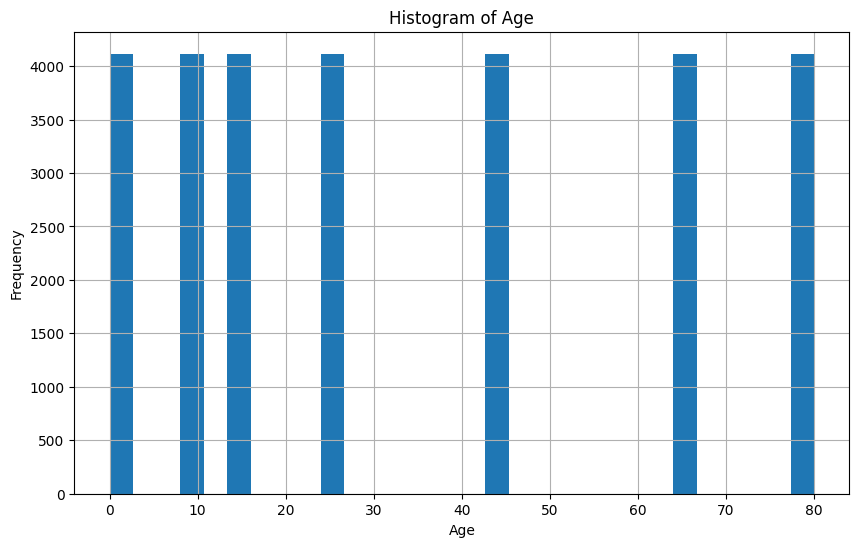

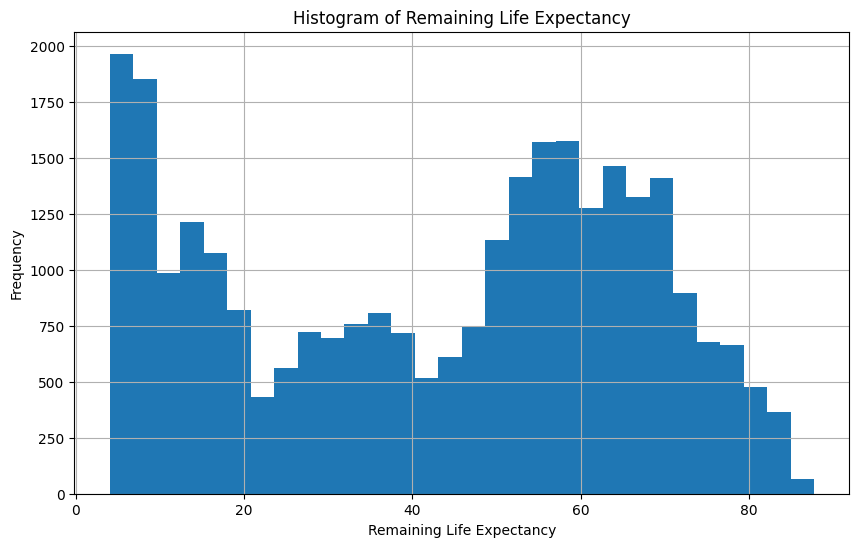

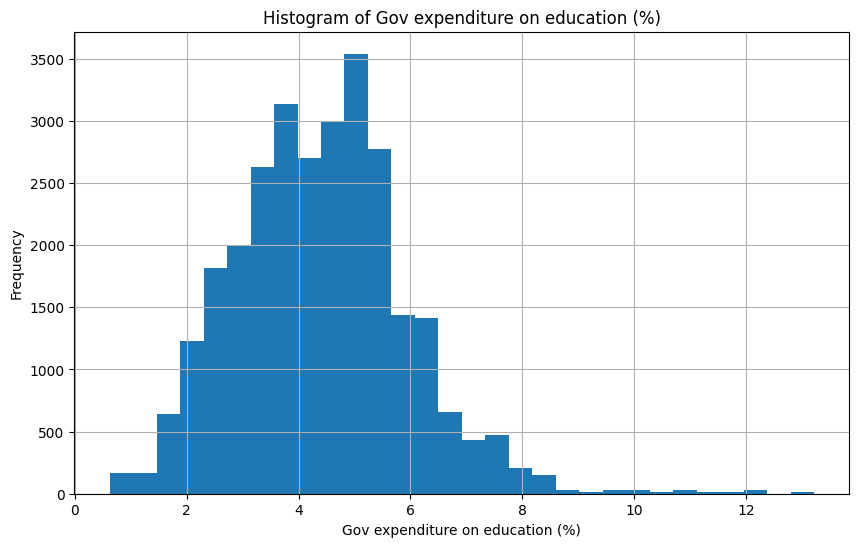

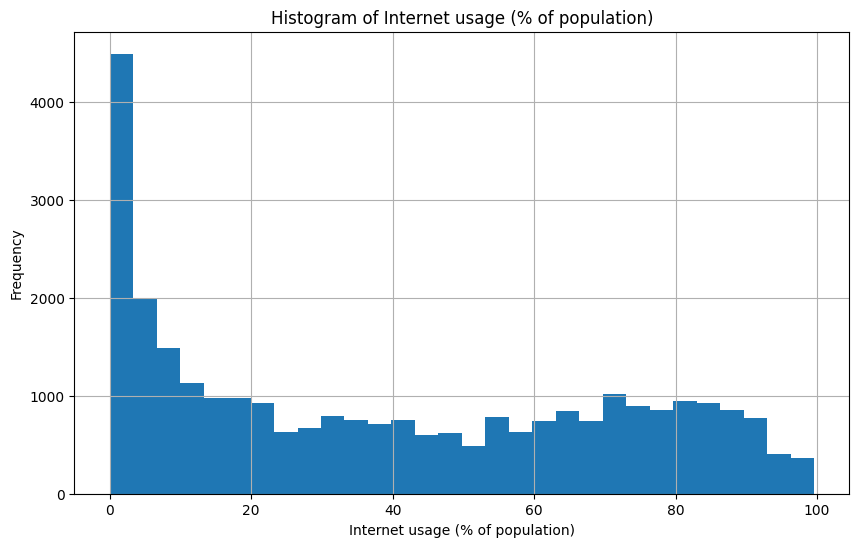

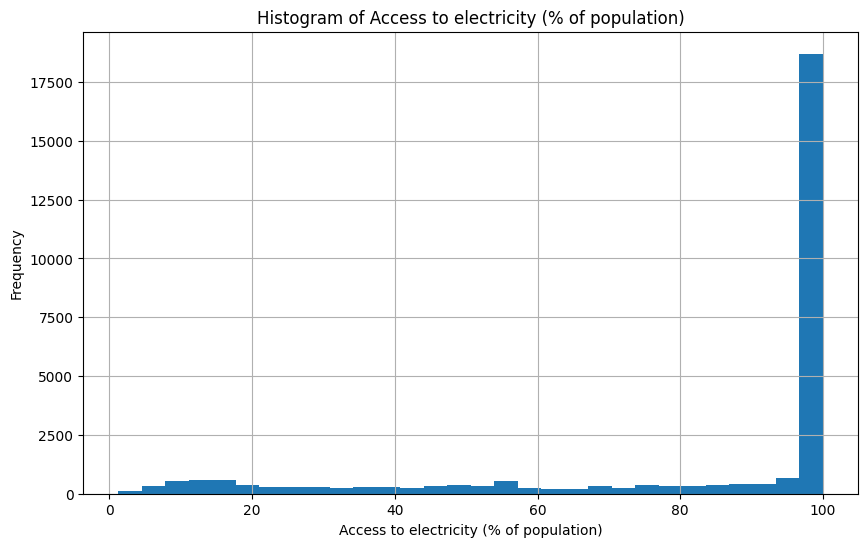

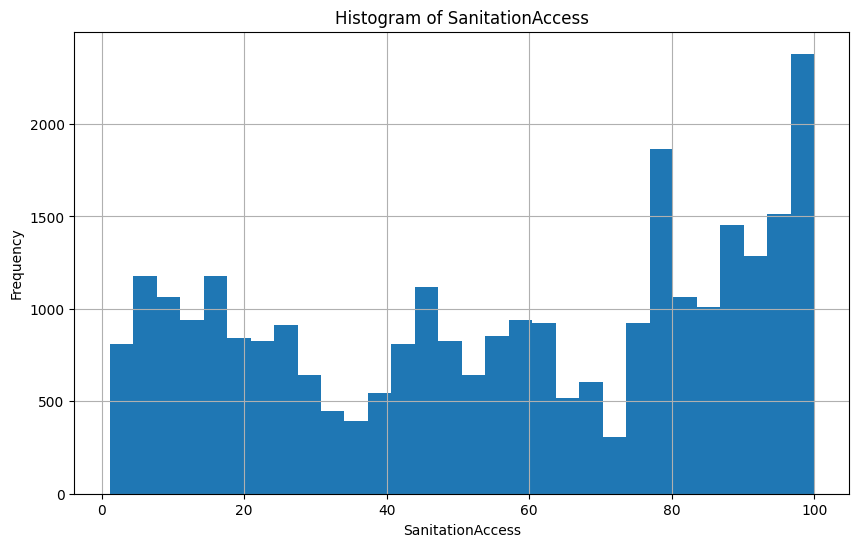

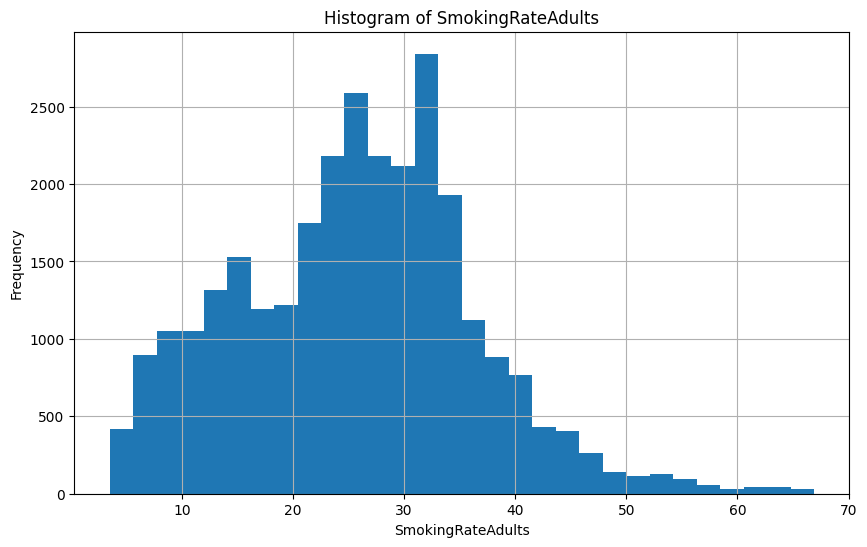

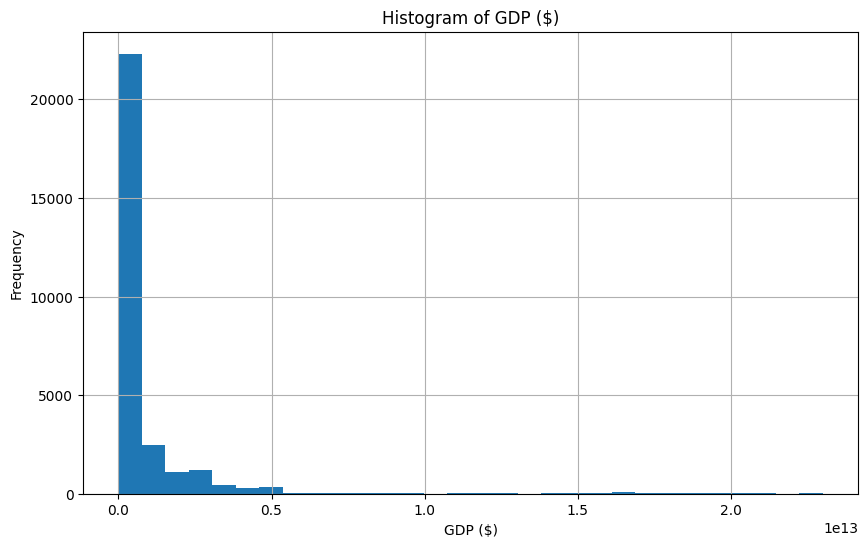

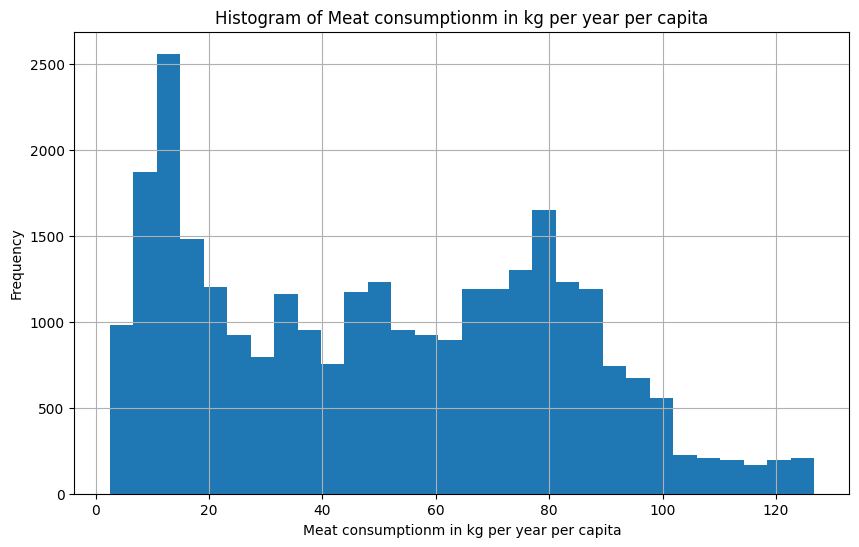

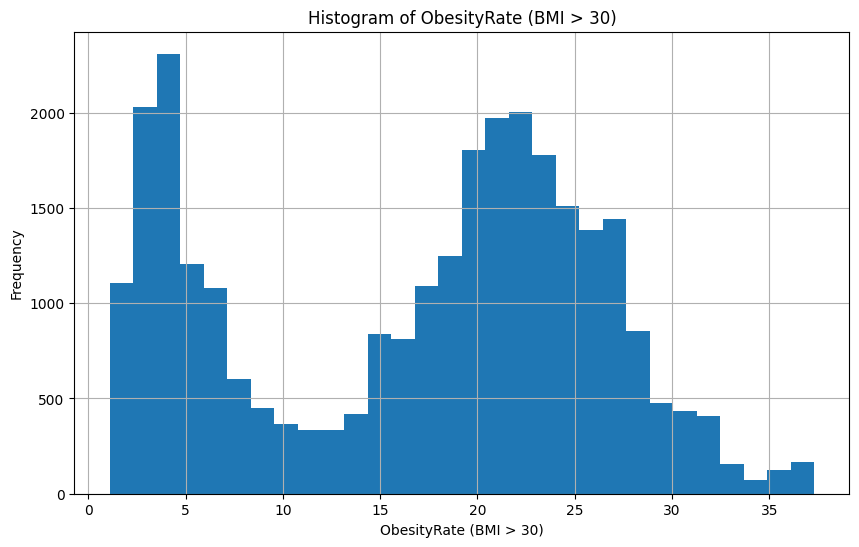

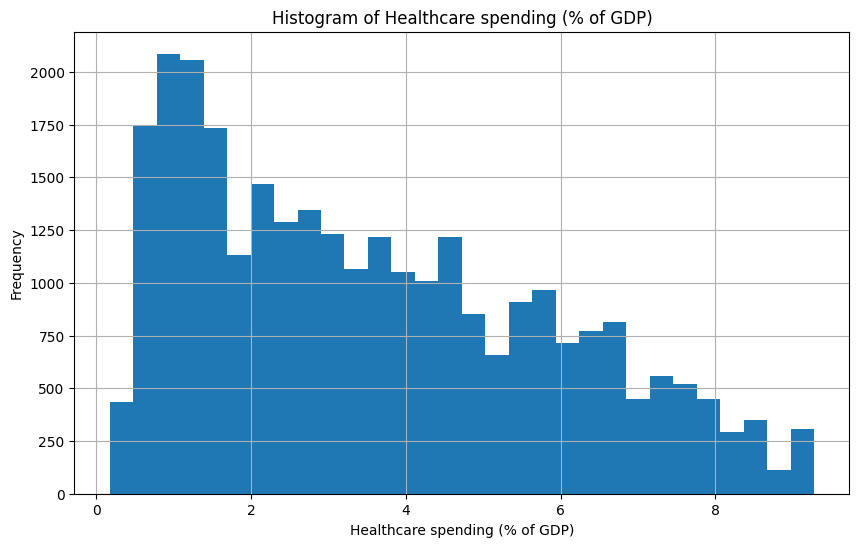

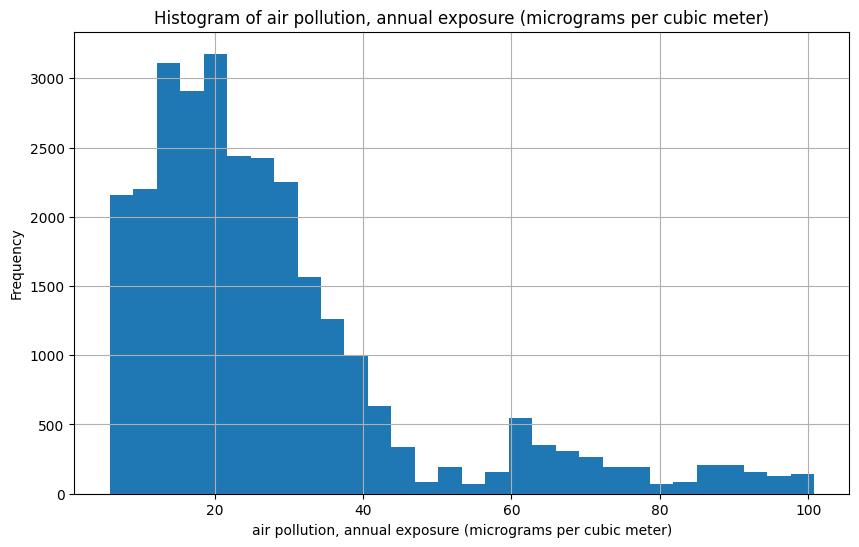

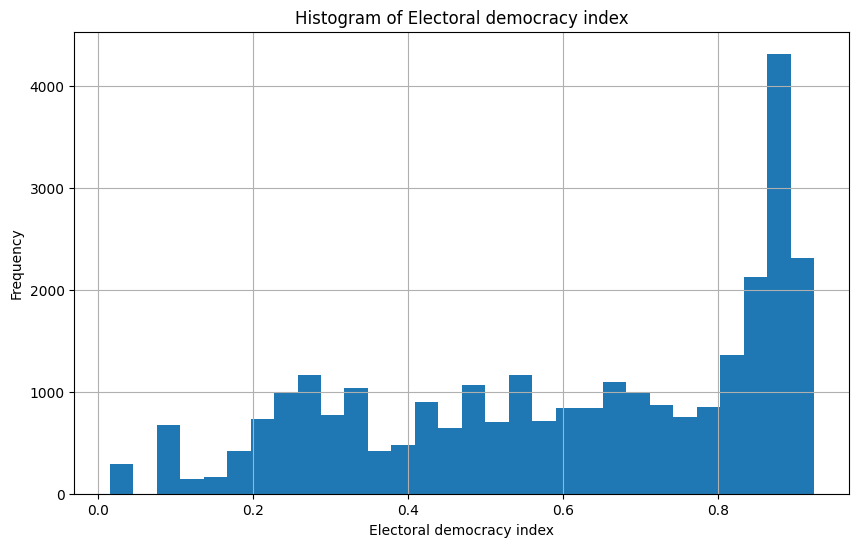

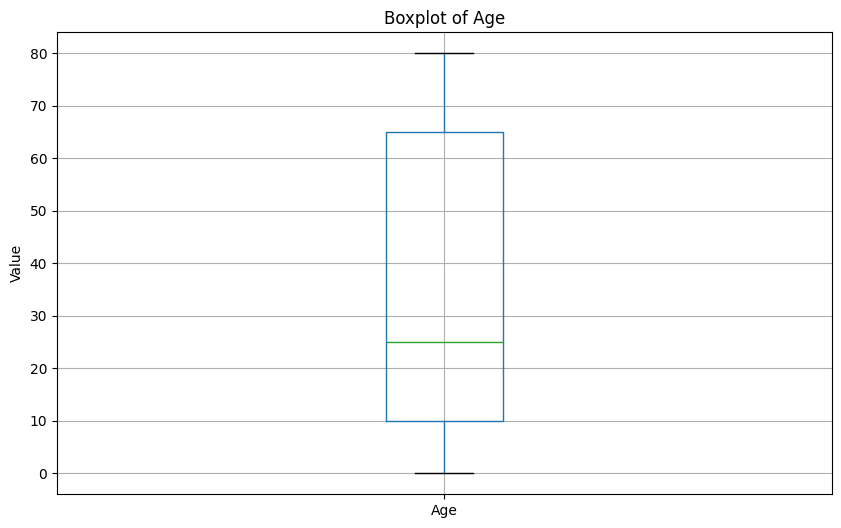

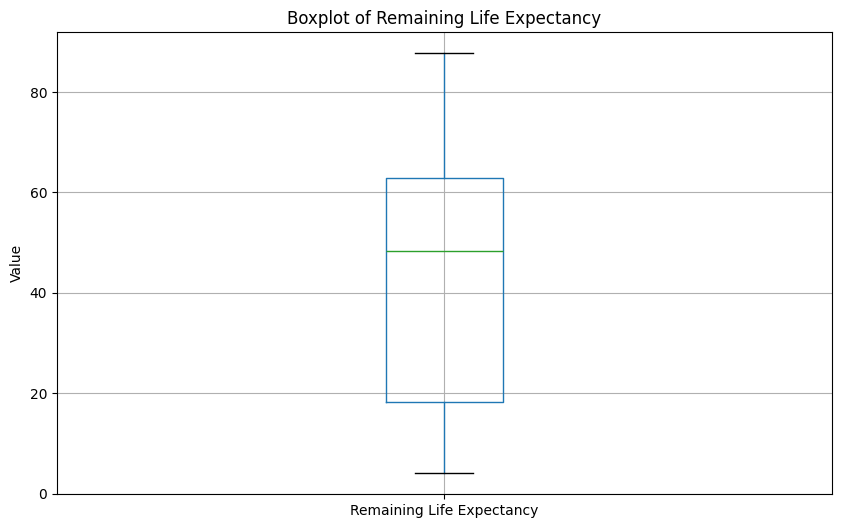

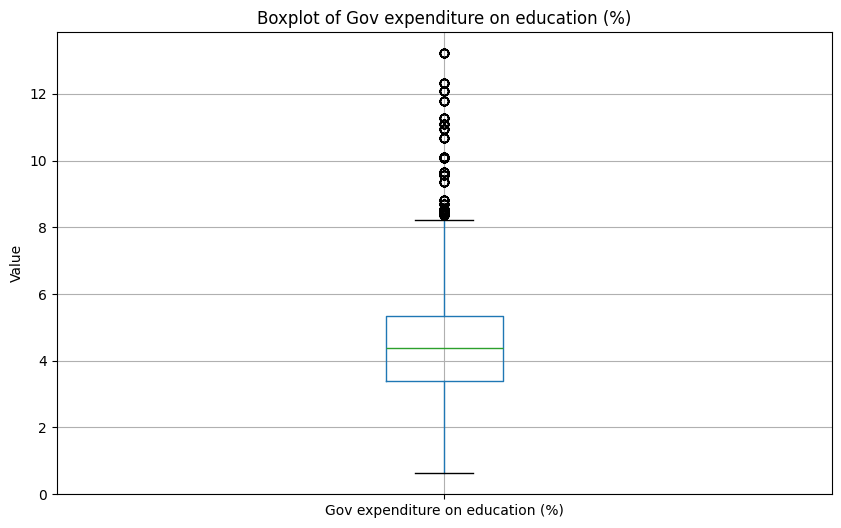

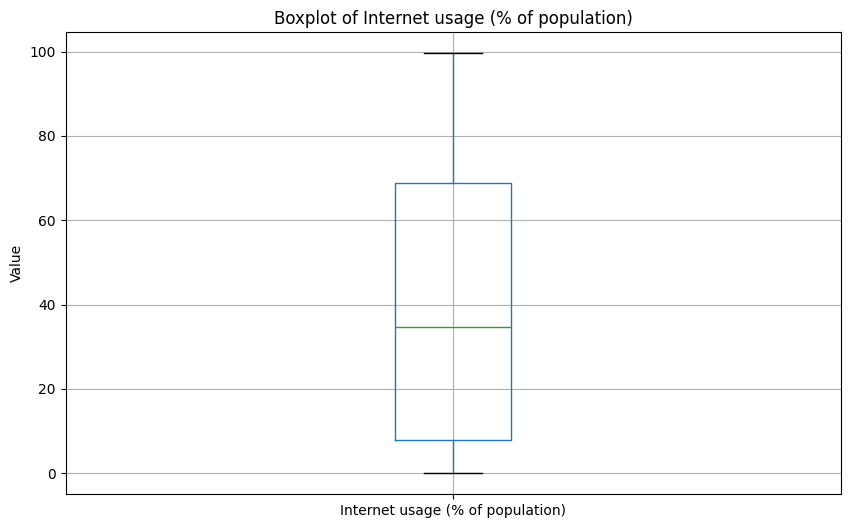

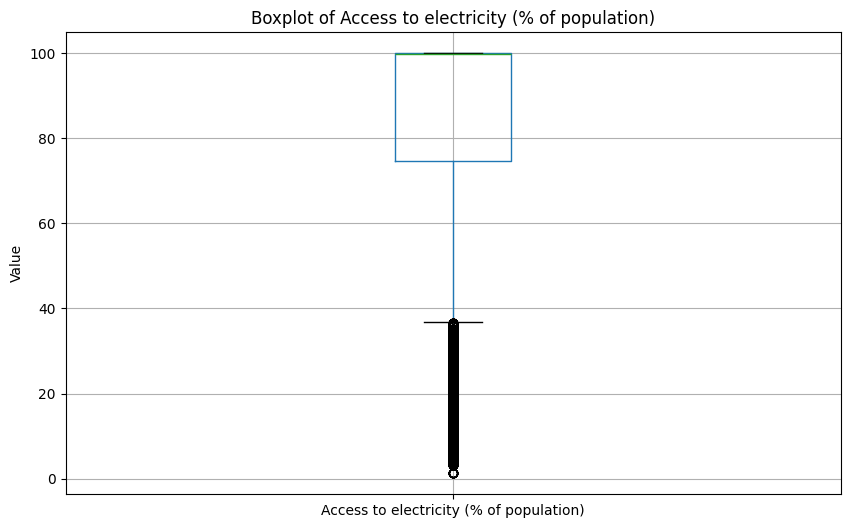

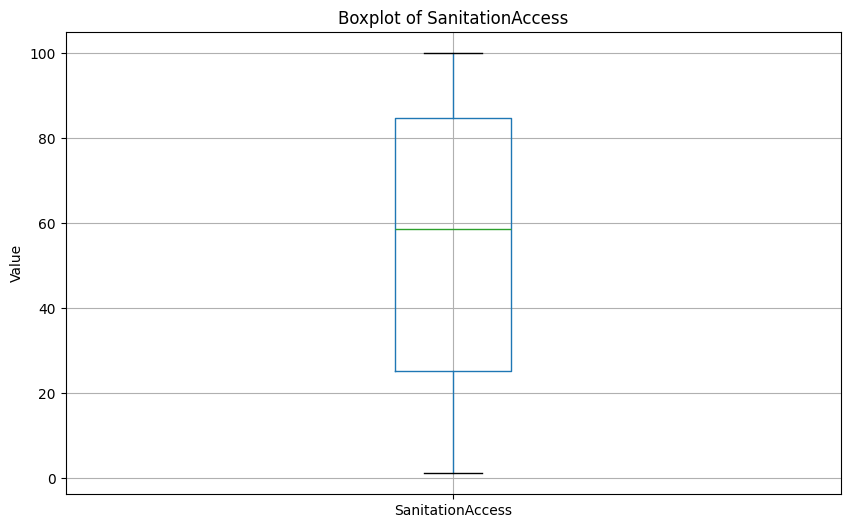

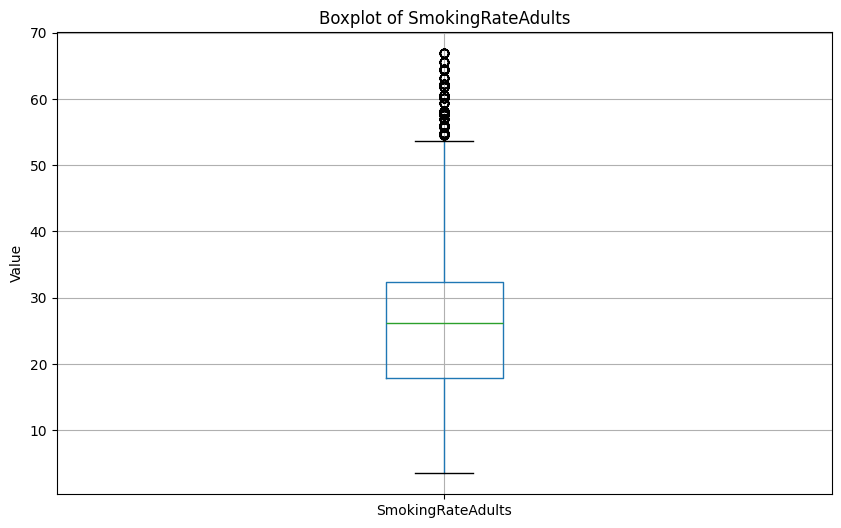

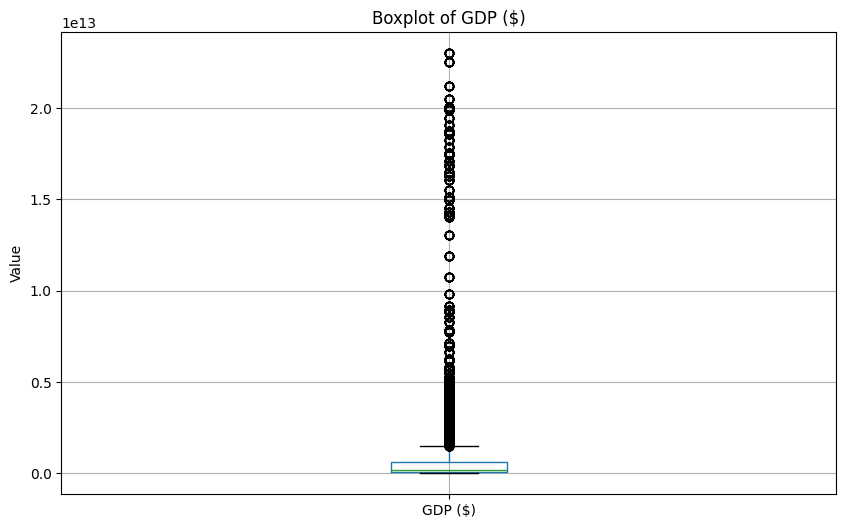

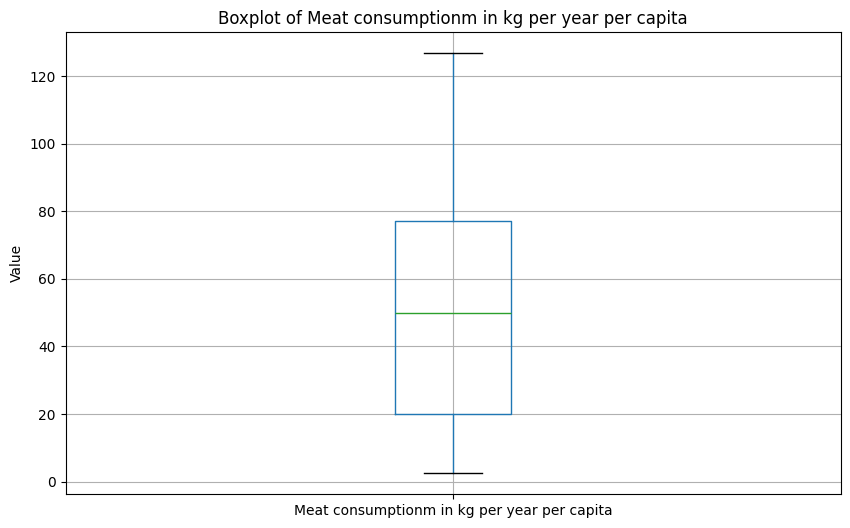

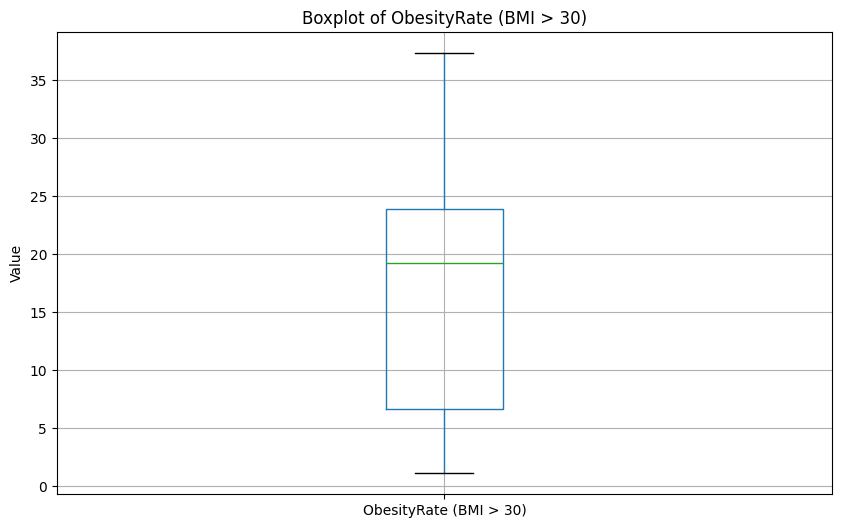

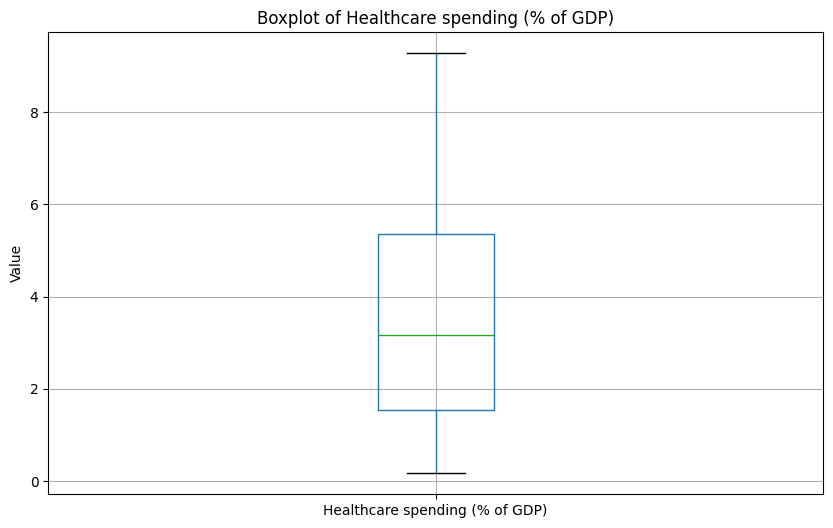

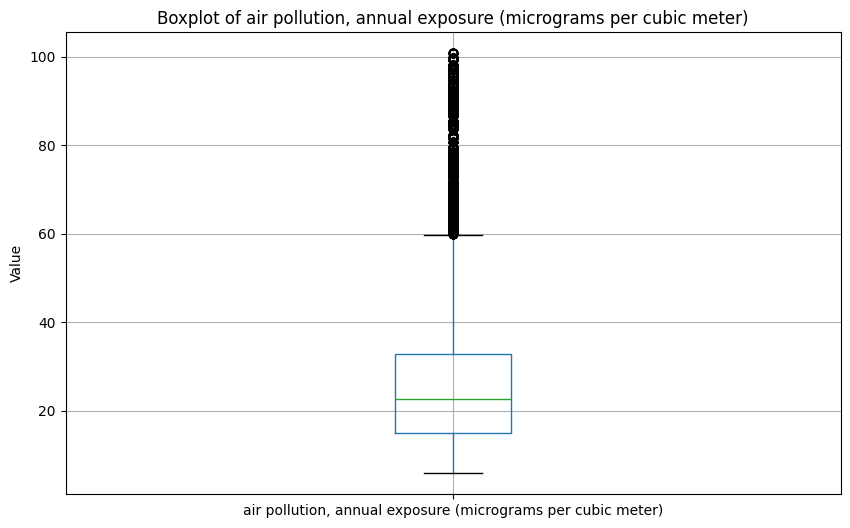

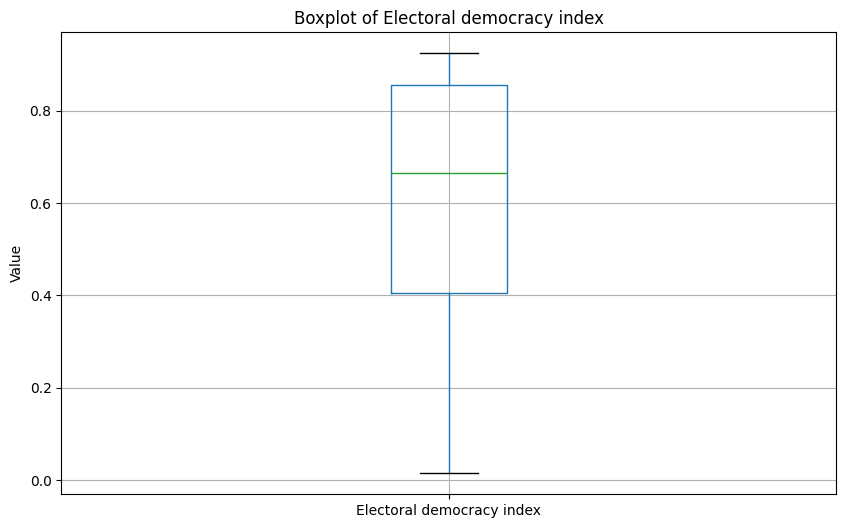

In [18]:
# Display basic descriptive statistics
print("Descriptive Statistics:")
print(final_df.describe())
 
# Histograms for columns, excluding 'Year'
for column in final_df.columns:
    # Check if the column is numerical and not 'Year'
    if final_df[column].dtype in ['int64', 'float64'] and column != 'Year':
        plt.figure(figsize=(10, 6))
        final_df[column].hist(bins=30)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

# Boxplots for potential outlier detection in specific columns, excluding 'Year'
for column in final_df.columns:
    # Check if the column is numerical and not 'Year'
    if final_df[column].dtype in ['int64', 'float64'] and column != 'Year':
        plt.figure(figsize=(10, 6))
        final_df.boxplot(column)
        plt.title(f'Boxplot of {column}')
        plt.ylabel('Value')
        plt.show()

# Feature Selection & Engineering

### Binary encoding

In [19]:

final_df2 = final_df.drop('Code', axis=1)
 
# Selected columns for binary encoding
columns_to_encode = ['Sex', 'Entity']
 
# Create a new DataFrame for training with binary encoding
encoder = ce.BinaryEncoder(cols=columns_to_encode, drop_invariant=True, return_df=True)

training_dataset = encoder.fit_transform(final_df2)
 
# Save the original column names before encoding
original_columns = encoder.get_feature_names_out()
 
# Save the result

training_dataset.to_csv('generated-data/training_dataset_binary.csv', index=False)
 
# Back-encode to get the original DataFrame
original_df = encoder.inverse_transform(training_dataset[original_columns])
 
training_dataset

,Entity_0,Entity_1,Entity_2,Entity_3,Entity_4,Entity_5,Entity_6,Year,Sex_0,Sex_1,...,Internet usage (% of population),Access to electricity (% of population),SanitationAccess,SmokingRateAdults,GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
42,0,0,0,0,0,0,1,2000,0,1,...,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
43,0,0,0,0,0,0,1,2001,0,1,...,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
44,0,0,0,0,0,0,1,2002,0,1,...,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
45,0,0,0,0,0,0,1,2003,0,1,...,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
46,0,0,0,0,0,0,1,2004,0,1,...,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69148,1,1,0,0,0,1,0,2016,1,0,...,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
69149,1,1,0,0,0,1,0,2017,1,0,...,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
69150,1,1,0,0,0,1,0,2018,1,0,...,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
69151,1,1,0,0,0,1,0,2019,1,0,...,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


### Onehot encoding

In [20]:
final_df2 = final_df.drop('Code', axis=1)

# Selected columns for one-hot encoding
columns_to_encode = ['Sex', 'Entity']

# Create a new DataFrame for training with one-hot encoding
encoder = ce.OneHotEncoder(cols=columns_to_encode, use_cat_names=True)

training_dataset_onehot = encoder.fit_transform(final_df2)

# Save the result as CSV
training_dataset_onehot.to_csv('generated-data/training_dataset_onehot.csv', index=False)

training_dataset_onehot

,Entity_Algeria,Entity_Argentina,Entity_Armenia,Entity_Australia,Entity_Austria,Entity_Azerbaijan,Entity_Bangladesh,Entity_Belarus,Entity_Belgium,Entity_Benin,...,Internet usage (% of population),Access to electricity (% of population),SanitationAccess,SmokingRateAdults,GDP ($),Meat consumptionm in kg per year per capita,ObesityRate (BMI > 30),Healthcare spending (% of GDP),"air pollution, annual exposure (micrograms per cubic meter)",Electoral democracy index
42,1,0,0,0,0,0,0,0,0,0,...,0.491706,98.97310,58.85,22.200000,2.703917e+11,18.933718,15.0,2.510828,37.536050,0.326
43,1,0,0,0,0,0,0,0,0,0,...,0.646114,98.96687,59.19,22.120000,2.785034e+11,17.341906,15.5,2.925499,37.200605,0.326
44,1,0,0,0,0,0,0,0,0,0,...,1.591641,98.95306,59.53,22.040000,2.940996e+11,18.096855,16.1,2.807926,36.865160,0.329
45,1,0,0,0,0,0,0,0,0,0,...,2.195360,98.93401,59.86,21.960000,3.152748e+11,19.324575,16.7,2.761790,36.529716,0.335
46,1,0,0,0,0,0,0,0,0,0,...,4.634475,98.91208,60.18,21.880000,3.288316e+11,21.336285,17.3,2.528820,36.194271,0.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69148,0,0,0,0,0,0,0,0,0,0,...,85.544420,100.00000,97.19,24.666667,1.905248e+13,118.195300,37.3,8.557327,7.406464,0.884
69149,0,0,0,0,0,0,0,0,0,0,...,87.274890,100.00000,97.16,24.033333,1.947962e+13,119.273290,37.3,8.512190,7.409441,0.820
69150,0,0,0,0,0,0,0,0,0,0,...,88.498900,100.00000,97.14,23.400000,2.005337e+13,123.623640,37.3,8.472342,7.409441,0.813
69151,0,0,0,0,0,0,0,0,0,0,...,89.430280,100.00000,97.11,23.400000,2.051348e+13,126.303100,37.3,8.524923,7.409441,0.800


### List the encodings (for application)

In [21]:
# Extract binary encoded 'Entity' columns
binary_encoded_entities = training_dataset.filter(regex='^Entity_')

# Retrieve the original 'Entity' values from the back-encoded DataFrame
original_entities = original_df['Entity']

# Create a DataFrame that pairs each original 'Entity' with its binary encoding
entity_binary_encoding = pd.concat([original_entities, binary_encoded_entities], axis=1).drop_duplicates()

# Convert the DataFrame to a list of tuples for easier reading
entity_binary_encoding_list = list(entity_binary_encoding.itertuples(index=False, name=None))

# Print the list to see the original 'Entity' and their binary encodings
for item in entity_binary_encoding_list:
    print(item)

# Convert the list of tuples back into a DataFrame
entity_binary_encoding_df = pd.DataFrame(entity_binary_encoding_list, columns=['Entity'] + binary_encoded_entities.columns.tolist())

# Save this DataFrame to a CSV file
entity_binary_encoding_df.to_csv('frontend/countries.csv', index=False)

('Algeria', 0, 0, 0, 0, 0, 0, 1)
('Argentina', 0, 0, 0, 0, 0, 1, 0)
('Armenia', 0, 0, 0, 0, 0, 1, 1)
('Australia', 0, 0, 0, 0, 1, 0, 0)
('Austria', 0, 0, 0, 0, 1, 0, 1)
('Azerbaijan', 0, 0, 0, 0, 1, 1, 0)
('Bangladesh', 0, 0, 0, 0, 1, 1, 1)
('Belarus', 0, 0, 0, 1, 0, 0, 0)
('Belgium', 0, 0, 0, 1, 0, 0, 1)
('Benin', 0, 0, 0, 1, 0, 1, 0)
('Brazil', 0, 0, 0, 1, 0, 1, 1)
('Bulgaria', 0, 0, 0, 1, 1, 0, 0)
('Burkina Faso', 0, 0, 0, 1, 1, 0, 1)
('Cambodia', 0, 0, 0, 1, 1, 1, 0)
('Canada', 0, 0, 0, 1, 1, 1, 1)
('Chad', 0, 0, 1, 0, 0, 0, 0)
('Chile', 0, 0, 1, 0, 0, 0, 1)
('China', 0, 0, 1, 0, 0, 1, 0)
('Colombia', 0, 0, 1, 0, 0, 1, 1)
('Costa Rica', 0, 0, 1, 0, 1, 0, 0)
("Cote d'Ivoire", 0, 0, 1, 0, 1, 0, 1)
('Croatia', 0, 0, 1, 0, 1, 1, 0)
('Cyprus', 0, 0, 1, 0, 1, 1, 1)
('Czechia', 0, 0, 1, 1, 0, 0, 0)
('Denmark', 0, 0, 1, 1, 0, 0, 1)
('Dominican Republic', 0, 0, 1, 1, 0, 1, 0)
('Ecuador', 0, 0, 1, 1, 0, 1, 1)
('Egypt', 0, 0, 1, 1, 1, 0, 0)
('Estonia', 0, 0, 1, 1, 1, 0, 1)
('Ethiopia', 0, 0, 

### Correlation Matrix

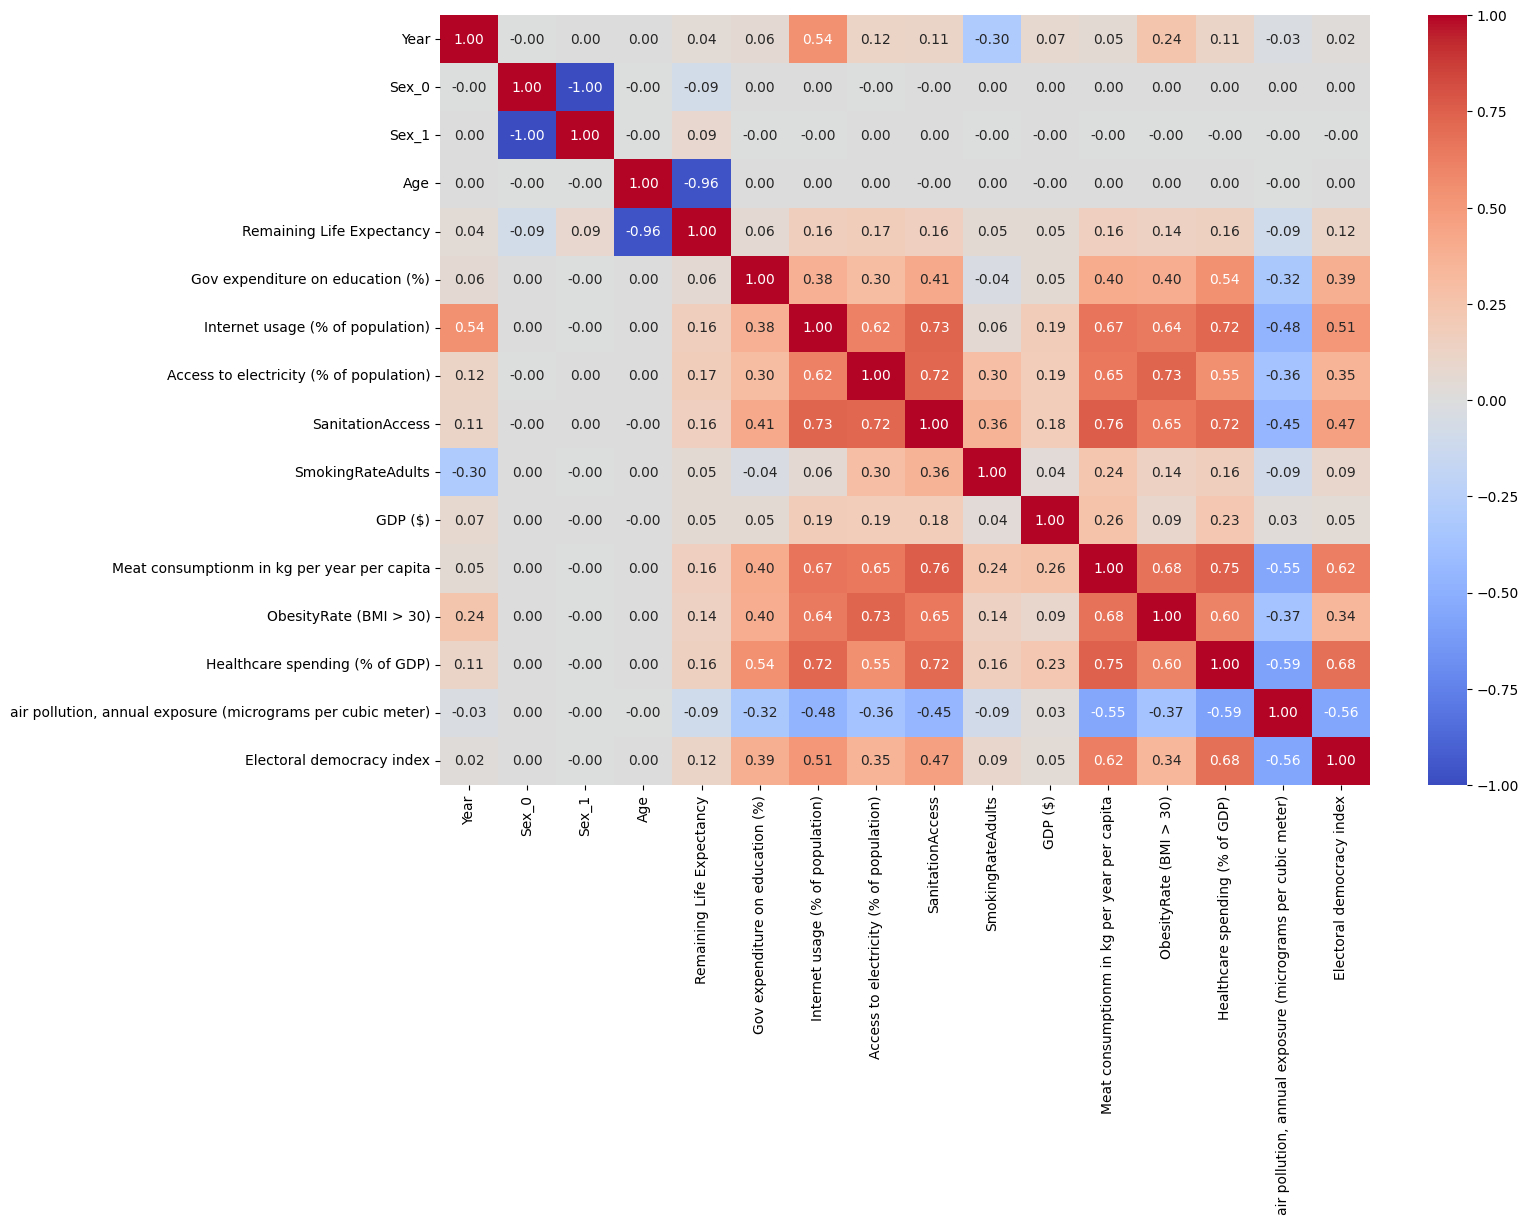

In [22]:
# Exclude columns 'Entity_0' to 'Entity_6' from the correlation matrix
columns_to_exclude = [f'Entity_{i}' for i in range(7)]  # Assuming you have 'Entity_0' to 'Entity_6'
correlation_matrix = training_dataset.drop(columns=columns_to_exclude).corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot (Sex_0 = 1 = Female) 
plt.show()


# Anwendung in Machine Learning

### Linear regression SGD

In [23]:
def train_and_evaluate(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Splitting the data
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Creating and training the SGD Regressor
    sgd_reg = SGDRegressor(random_state=42)
    sgd_reg.fit(X_train_scaled, y_train)

    # Predictions and Evaluation
    y_pred = sgd_reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'model': sgd_reg,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'metrics': {'RMSE': rmse, 'R2': r2},
        'feature_names': X.columns 
    }

# Running the function for both datasets
results_binary = train_and_evaluate('generated-data/training_dataset_binary.csv')
results_onehot = train_and_evaluate('generated-data/training_dataset_onehot.csv')


# Printing results and saving metrics
metrics = {
    'sgd_binary': results_binary['metrics'],
    'sgd_onehot': results_onehot['metrics']
}
#SGD
print(f"Metrics for Binary Encoded Data: {metrics['sgd_binary']}")
print(f"Metrics for One-Hot Encoded Data: {metrics['sgd_onehot']}")

Metrics for Binary Encoded Data: {'RMSE': 3.8035022828843736, 'R2': 0.9744782964094608}
Metrics for One-Hot Encoded Data: {'RMSE': 3.257327931346037, 'R2': 0.9812817490846066}


### XGBoost

In [26]:
def train_and_evaluate_xgb(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror')

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return {
        'model': model,
        'X_train': X_train,
        'X_test': X_test,
        'metrics': {'RMSE': rmse, 'R2': r2}
    }

# Running the function for the binary dataset
xgb_results_binary = train_and_evaluate_xgb('generated-data/training_dataset_binary.csv')

# Save the binary model
joblib.dump(xgb_results_binary['model'], 'frontend/xgb_model_binary.joblib')

# Running the function for the one-hot dataset
xgb_results_onehot = train_and_evaluate_xgb('generated-data/training_dataset_onehot.csv')


# Printing only the metrics
print("XGBoost Metrics:")
print(f"Binary Encoded Data: RMSE = {xgb_results_binary['metrics']['RMSE']}, R2 = {xgb_results_binary['metrics']['R2']}")
print(f"One-Hot Encoded Data: RMSE = {xgb_results_onehot['metrics']['RMSE']}, R2 = {xgb_results_onehot['metrics']['R2']}")

# Adding XGBoost metrics to the metrics dictionary
metrics['xgboost_binary'] = xgb_results_binary['metrics']
metrics['xgboost_onehot'] = xgb_results_onehot['metrics']


XGBoost Metrics:
Binary Encoded Data: RMSE = 0.6308407198759984, R2 = 0.9992979278668134
One-Hot Encoded Data: RMSE = 0.7057129203413719, R2 = 0.9991213853603909


### Random Forest

In [27]:
def train_and_evaluate_rf(dataset_filename):
    # Load the dataset
    data = pd.read_csv(dataset_filename)

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1)
    y = data['Remaining Life Expectancy']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest Regressor
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
   
    return {
        'model': rf_model,
        'X': X,
        'y': y,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'metrics': {'RMSE': rmse, 'R2': r2}
    }

# Running the function for both datasets
rf_metrics_binary = train_and_evaluate_rf('generated-data/training_dataset_binary.csv')
rf_metrics_onehot = train_and_evaluate_rf('generated-data/training_dataset_onehot.csv')
 
# Printing only the metrics
print("Random Forest Metrics:")
print(f"Binary Encoded Data: RMSE = {rf_metrics_binary['metrics']['RMSE']}, R2 = {rf_metrics_binary['metrics']['R2']}")
print(f"One-Hot Encoded Data: RMSE = {rf_metrics_onehot['metrics']['RMSE']}, R2 = {rf_metrics_onehot['metrics']['R2']}")
 
# Adding Random Forest metrics to the metrics dictionary
metrics['rf_binary'] = rf_metrics_binary['metrics']
metrics['rf_onehot'] = rf_metrics_onehot['metrics']

Random Forest Metrics:
Binary Encoded Data: RMSE = 0.6651699751797568, R2 = 0.9992194376975022
One-Hot Encoded Data: RMSE = 0.6462076678821754, R2 = 0.9992633070529581


In [28]:
def plot_validation_curve(X_train, y_train, title_suffix):
    param_range = [10, 20, 30, 40, 50, 100]
    train_scores, test_scores = validation_curve(
        RandomForestRegressor(random_state=42), X_train, y_train, param_name='n_estimators', param_range=param_range,
        cv=5, scoring='neg_mean_squared_error'
    )

    # Convert from negative MSE to RMSE
    train_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_mean = np.sqrt(-np.mean(test_scores, axis=1))

    # Plotting the validation curve
    plt.plot(param_range, train_mean, label='Training Error')
    plt.plot(param_range, test_mean, label='Test Error')
    plt.xlabel('Number of Trees')
    plt.ylabel('RMSE')
    plt.title(f'Random Forest Regressor Validation Curve - {title_suffix}')
    plt.legend()
    plt.show()

# Running the function for both datasets
rf_results_binary = train_and_evaluate_rf('generated-data/training_dataset_binary.csv')
rf_results_onehot = train_and_evaluate_rf('generated-data/training_dataset_onehot.csv')

# Plotting validation curves for both datasets
plot_validation_curve(rf_results_binary['X_train'], rf_results_binary['y_train'], 'Binary Encoded Data')
plot_validation_curve(rf_results_onehot['X_train'], rf_results_onehot['y_train'], 'One-Hot Encoded Data')

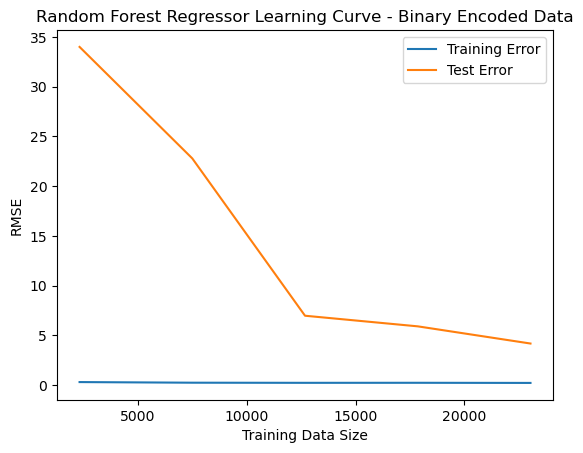

In [ ]:
def plot_learning_curve(model, X, y, title_suffix):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error'
    )

    # Convert from negative MSE to RMSE
    train_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_mean = np.sqrt(-np.mean(test_scores, axis=1))

    # Plotting the learning curve
    plt.plot(train_sizes, train_mean, label='Training Error')
    plt.plot(train_sizes, test_mean, label='Test Error')
    plt.xlabel('Training Data Size')
    plt.ylabel('RMSE')
    plt.title(f'Random Forest Regressor Learning Curve - {title_suffix}')
    plt.legend()
    plt.show()

# Plotting learning curves for both datasets
plot_learning_curve(rf_results_binary['model'], rf_results_binary['X'], rf_results_binary['y'], 'Binary Encoded Data')
plot_learning_curve(rf_results_onehot['model'], rf_results_onehot['X'], rf_results_onehot['y'], 'One-Hot Encoded Data')

#### Feedforward Network

In [ ]:
torch.manual_seed(42)

class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

def train_and_evaluate_nn(dataset_filename, save_model=False):
    # Load the dataset
    data = pd.read_csv(dataset_filename)  

    # Separate the features and the target variable
    X = data.drop('Remaining Life Expectancy', axis=1).values
    y = data['Remaining Life Expectancy'].values

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    # Create PyTorch datasets and DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

    # Model, Loss, and Optimizer
    model = NeuralNet(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    patience = 20
    best_loss = float('inf')
    epochs_no_improve = 0

    # Training the Model
    num_epochs = 200
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()  # Evaluation mode
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

        # Check for early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs!')
            break

    # Evaluate the model on test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    y_test_pred = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
            y_test_pred.extend(outputs.numpy().squeeze())

    avg_test_loss = test_loss / len(test_loader)
    rmse = np.sqrt(avg_test_loss)
    r2 = r2_score(y_test, y_test_pred)

    # Save the model and scaler
    if save_model:
        joblib.dump(scaler, 'frontend/scaler.save')
        torch.save(model.state_dict(), 'frontend/FNN_model.pth')

    # Return the losses, metrics, and test_loader
    return {
        'metrics': {'RMSE': rmse, 'R2': r2}, 
        'train_losses': train_losses, 
        'val_losses': val_losses, 
        'test_loader': test_loader,
        'model': model
    }


# Running the function for both datasets
nn_metrics_binary = train_and_evaluate_nn('generated-data/training_dataset_binary.csv', save_model=True)
nn_metrics_onehot = train_and_evaluate_nn('generated-data/training_dataset_onehot.csv')

# Extract the trained model
model_binary = nn_metrics_binary['model']
model_onehot = nn_metrics_onehot['model']

# Test loaders for SHAP analysis
test_loader_binary = nn_metrics_binary['test_loader']
test_loader_onehot = nn_metrics_onehot['test_loader']

# Printing results
print("Neural Network Metrics:")
print(f"Binary Encoded Data: RMSE = {nn_metrics_binary['metrics']}")
print(f"One-Hot Encoded Data: RMSE = {nn_metrics_onehot['metrics']}")

# Adding Neural Network metrics to the existing metrics dictionary
metrics['nn_binary'] = nn_metrics_binary['metrics'] 
metrics['nn_onehot'] = nn_metrics_onehot['metrics']



Epoch [1/200], Validation Loss: 12.1415
Epoch [2/200], Validation Loss: 5.2597
Epoch [3/200], Validation Loss: 3.3735
Epoch [4/200], Validation Loss: 2.6181
Epoch [5/200], Validation Loss: 2.0885
Epoch [6/200], Validation Loss: 1.7358
Epoch [7/200], Validation Loss: 1.4270
Epoch [8/200], Validation Loss: 1.2207
Epoch [9/200], Validation Loss: 1.1486
Epoch [10/200], Validation Loss: 0.9692
Epoch [11/200], Validation Loss: 1.0052
Epoch [12/200], Validation Loss: 0.8481
Epoch [13/200], Validation Loss: 0.8344
Epoch [14/200], Validation Loss: 0.7461
Epoch [15/200], Validation Loss: 0.8868
Epoch [16/200], Validation Loss: 0.6935
Epoch [17/200], Validation Loss: 0.7261
Epoch [18/200], Validation Loss: 0.8180
Epoch [19/200], Validation Loss: 0.6401
Epoch [20/200], Validation Loss: 0.6284
Epoch [21/200], Validation Loss: 0.5347
Epoch [22/200], Validation Loss: 0.5049
Epoch [23/200], Validation Loss: 0.4671
Epoch [24/200], Validation Loss: 0.5474
Epoch [25/200], Validation Loss: 0.5367
Epoch [2

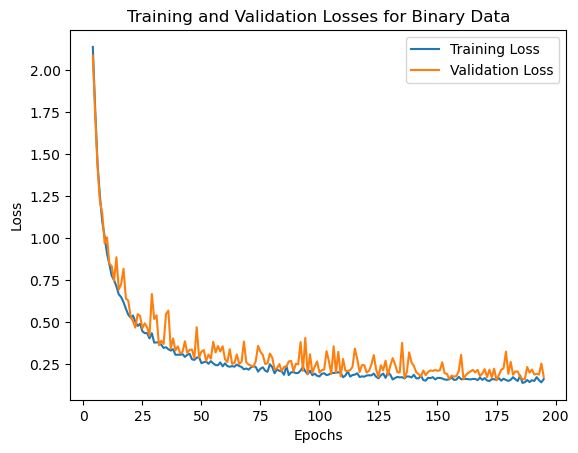

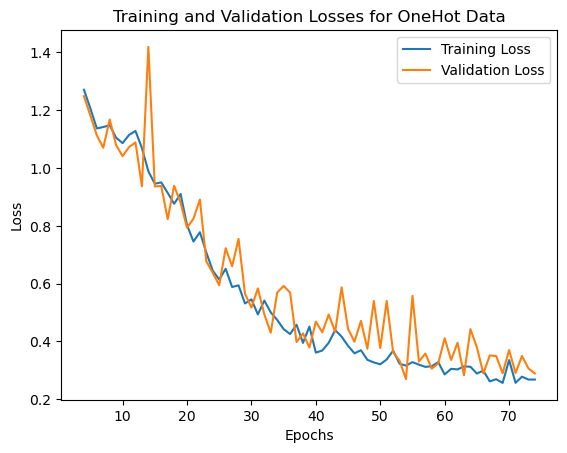

In [ ]:
# Plotting the training and validation losses
plt.plot(range(4, len(nn_metrics_binary['train_losses'])), nn_metrics_binary['train_losses'][4:], label='Training Loss')
plt.plot(range(4, len(nn_metrics_binary['val_losses'])), nn_metrics_binary['val_losses'][4:], label='Validation Loss')
plt.title('Training and Validation Losses for Binary Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation losses
plt.plot(range(4, len(nn_metrics_onehot['train_losses'])), nn_metrics_onehot['train_losses'][4:], label='Training Loss')
plt.plot(range(4, len(nn_metrics_onehot['val_losses'])), nn_metrics_onehot['val_losses'][4:], label='Validation Loss')
plt.title('Training and Validation Losses for OneHot Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Vergleich der Modelle

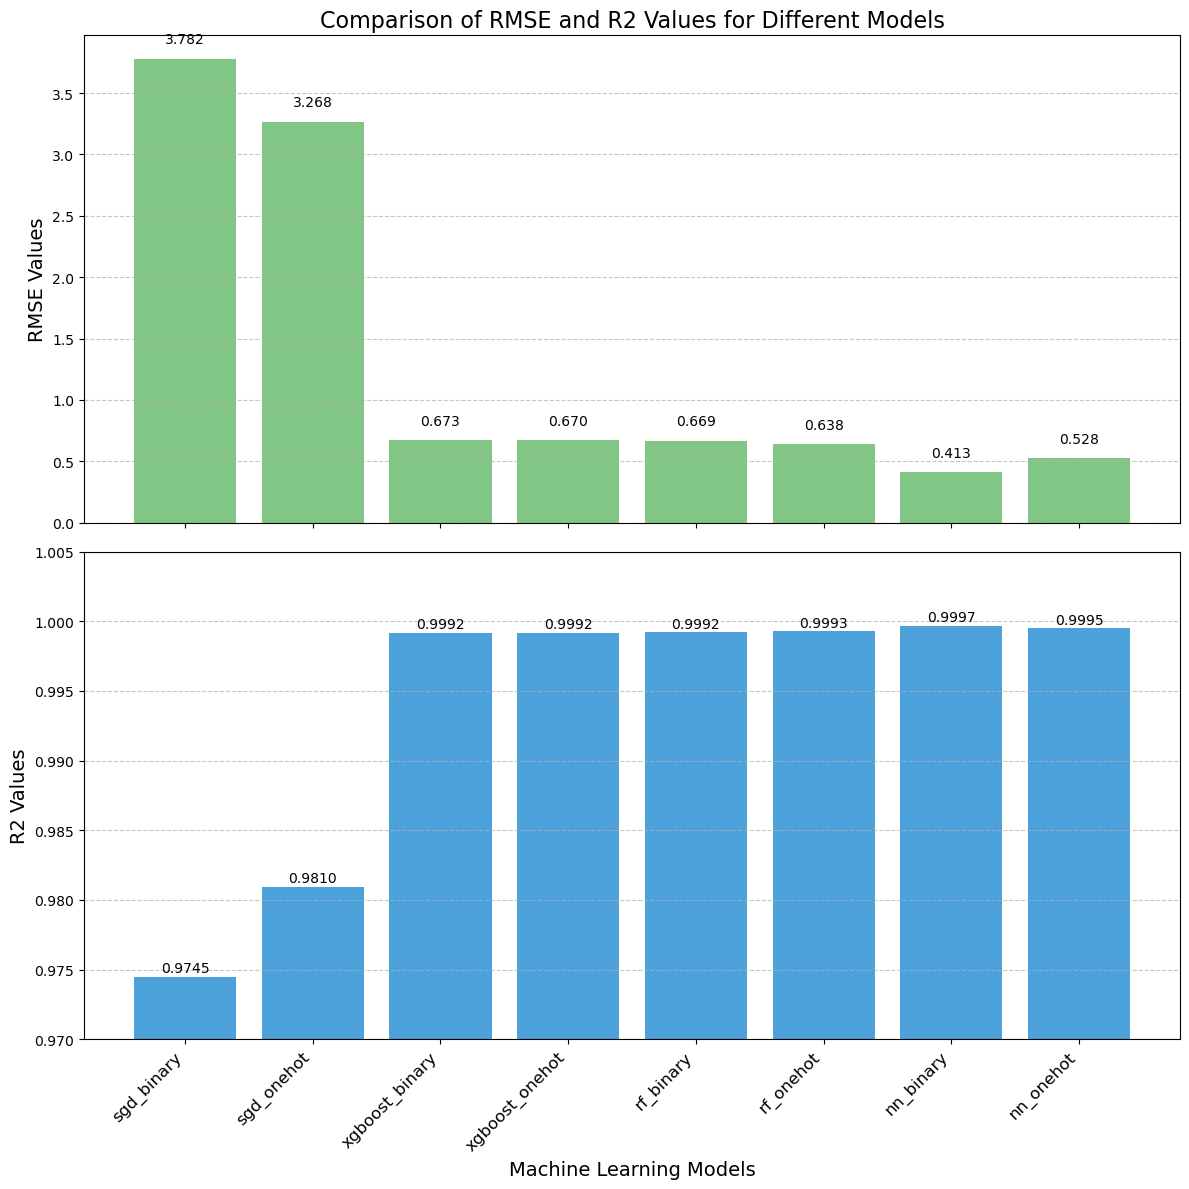

In [ ]:
# Extract models, RMSE, and R2 values
models = list(metrics.keys())
rmse_values = [metrics[model]['RMSE'] for model in models]
r2_values = [metrics[model]['R2'] for model in models]
 
# Create two subplots (for RMSE and R2)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
 
# Plot for RMSE values
ax1.bar(models, rmse_values, color='#4CAF50', alpha=0.7)
ax1.set_ylabel('RMSE Values', fontsize=14)
ax1.set_title('Comparison of RMSE and R2 Values for Different Models', fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
 
# Add RMSE values above the bars
for i, value in enumerate(rmse_values):
    ax1.text(i, value + 0.1, f'{value:.3f}', ha='center', va='bottom', fontsize=10, color='black')
 
# Plot for R2 values
ax2.bar(models, r2_values, color='#007ACC', alpha=0.7)
ax2.set_xlabel('Machine Learning Models', fontsize=14)
ax2.set_ylabel('R2 Values', fontsize=14)
ax2.set_ylim(min(r2_values) - 0.001, max(r2_values) + 0.001)  # Adjust y-axis limits for better scaling
ax2.set_yticks([round(value, 4) for value in ax2.get_yticks()])  # Adjust y-axis ticks for better precision
ax2.grid(axis='y', linestyle='--', alpha=0.7)
 
# Add R2 values above the bars
for i, value in enumerate(r2_values):
    ax2.text(i, value + 0.0001, f'{value:.4f}', ha='center', va='bottom', fontsize=10, color='black')
 
# Show the plots
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# Anwendung von XAI – Techniken

##### SDG Regression

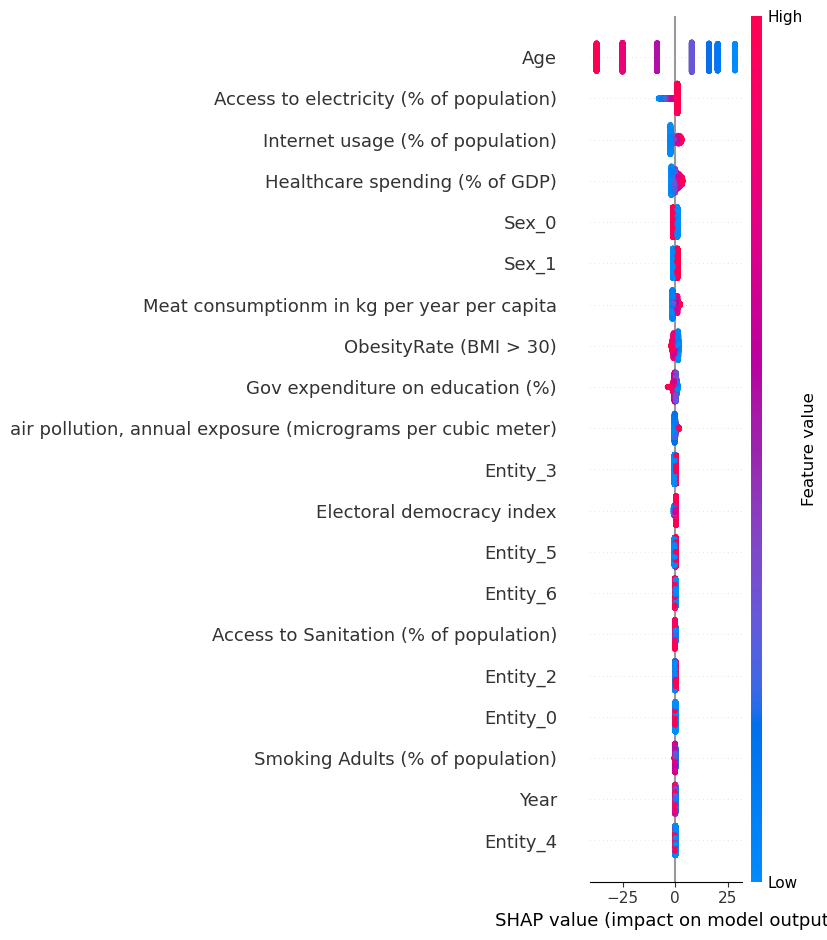

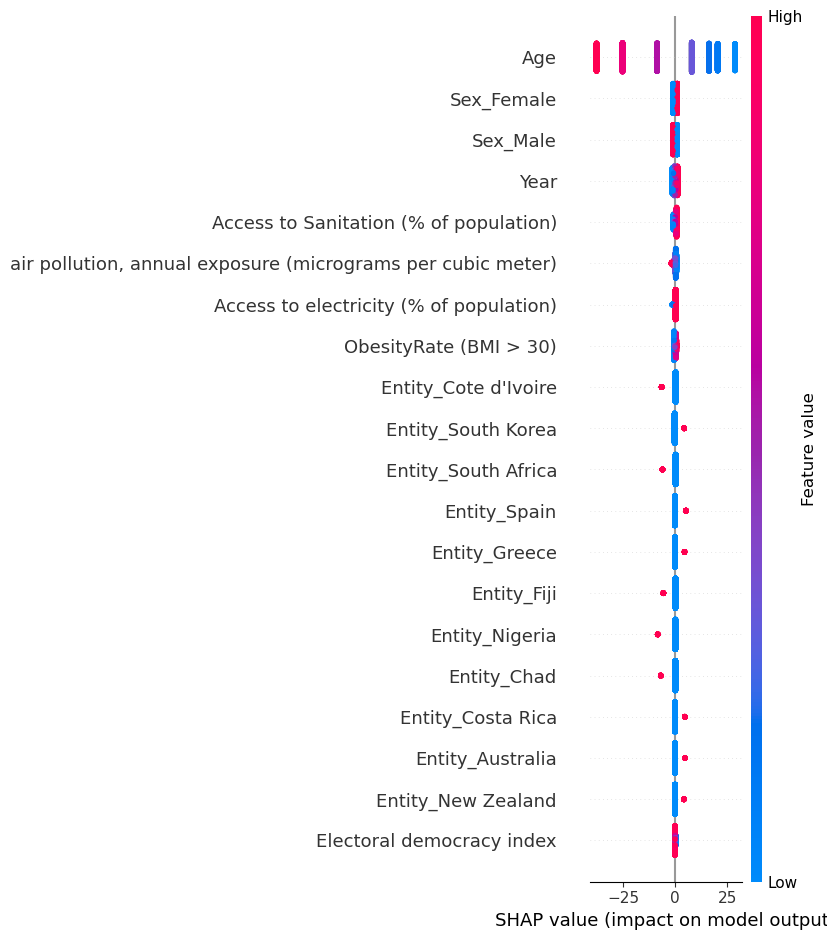

In [ ]:
# Creating SHAP explainers
explainer_binary_reg = shap.Explainer(results_binary['model'], results_binary['X_train_scaled'])
shap_values_binary_reg = explainer_binary_reg(results_binary['X_test_scaled'])

explainer_onehot_reg = shap.Explainer(results_onehot['model'], results_onehot['X_train_scaled'])
shap_values_onehot_reg = explainer_onehot_reg(results_onehot['X_test_scaled'])


# Visualizing SHAP values
shap.summary_plot(shap_values_binary_reg, results_binary['X_test_scaled'], feature_names=results_binary['feature_names'])
shap.summary_plot(shap_values_onehot_reg, results_onehot['X_test_scaled'], feature_names=results_onehot['feature_names'])

##### XGBoost

[12:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[12:03:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[12:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


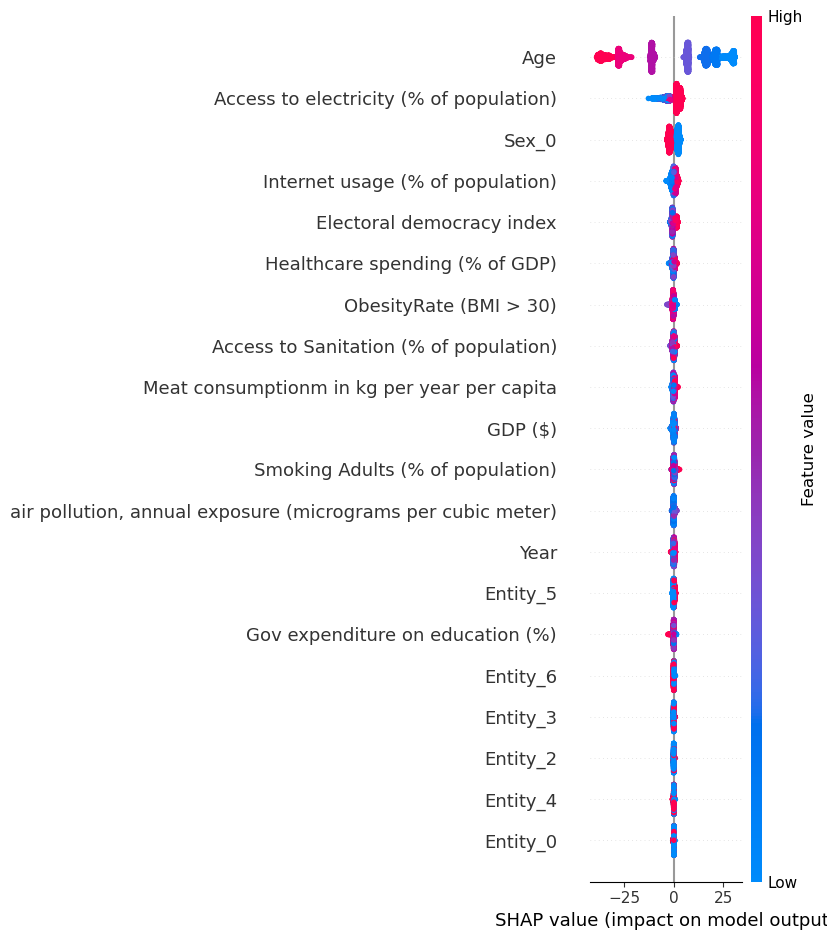

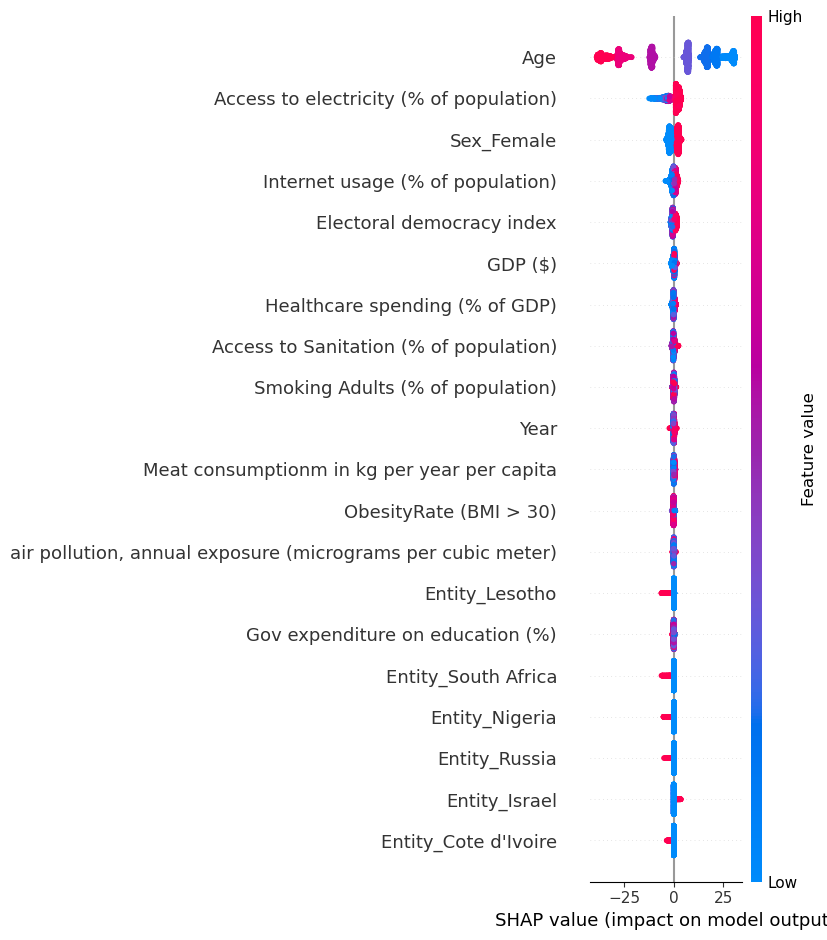

In [ ]:
# Running the function for both datasets
results_xgb_binary = train_and_evaluate_xgb('generated-data/training_dataset_binary.csv')
results_xgb_onehot = train_and_evaluate_xgb('generated-data/training_dataset_onehot.csv')

# Creating SHAP explainers for XGBoost models
explainer_xgb_binary = shap.Explainer(results_xgb_binary['model'])
shap_values_xgb_binary = explainer_xgb_binary(results_xgb_binary['X_test'])

explainer_xgb_onehot = shap.Explainer(results_xgb_onehot['model'])
shap_values_xgb_onehot = explainer_xgb_onehot(results_xgb_onehot['X_test'])

# Visualizing SHAP values
shap.summary_plot(shap_values_xgb_binary, results_xgb_binary['X_test'])
shap.summary_plot(shap_values_xgb_onehot, results_xgb_onehot['X_test'])


##### Random Forest

100%|===================| 5814/5822 [13:58<00:01]        

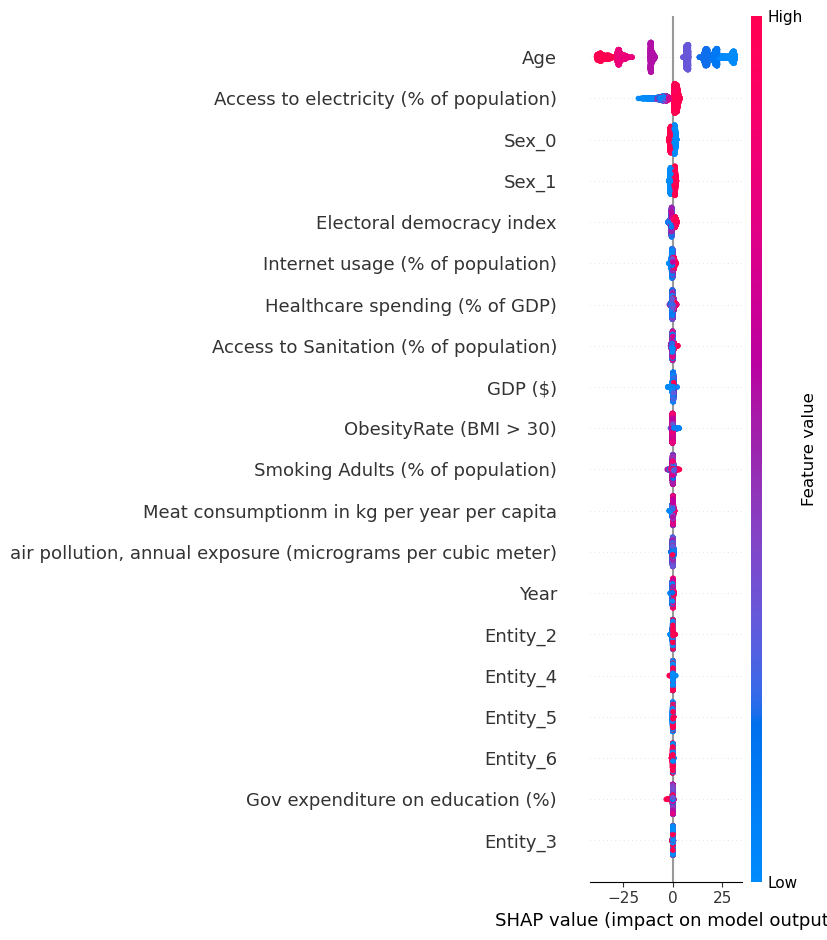

In [ ]:
def create_rf_shap_explainer(model, X_train):
    """ Function to create a SHAP explainer for the Random Forest model """
    explainer = shap.Explainer(model, X_train)
    return explainer

# Choose the dataset for SHAP analysis (binary or one-hot encoded)
rf_model_for_shap = rf_metrics_binary['model']  # or rf_metrics_onehot['model']
X_train_for_shap = rf_metrics_binary['X_train']  # or rf_metrics_onehot['X_train']
X_test_for_shap = rf_metrics_binary['X_test']  # or rf_metrics_onehot['X_test']

# Create SHAP explainer for the Random Forest model
explainer_rf = create_rf_shap_explainer(rf_model_for_shap, X_train_for_shap)

# Calculate SHAP values for the test dataset
shap_values_rf = explainer_rf(X_test_for_shap)

# Visualization of SHAP values
shap.summary_plot(shap_values_rf, X_test_for_shap)

##### FNN

Kernel explainer instead of DeepExplainer, easier and faster

In [ ]:
# load  data into a Pandas DataFrame for feature names
data = pd.read_csv('generated-data/training_dataset_binary.csv')

# Extract feature names
feature_names = data.drop('Remaining Life Expectancy', axis=1).columns.tolist()

# Function to make predictions from your neural network model
def model_predict(data):
    # Ensure data is a torch tensor
    data = torch.tensor(data, dtype=torch.float32)
    model_binary.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model_binary(data).numpy()  # Get predictions
    return predictions

# background dataset (could be a smaller random sample)
background_data = torch.cat([batch[0] for batch in test_loader_binary], dim=0).numpy()
background_sample = background_data[np.random.choice(background_data.shape[0], 1000, replace=False)]

# Create the SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(model_predict, background_sample)

# Calculate SHAP values for a sample of your test data
X_test_sample = background_data[:1000]  # Adjust this as needed
shap_values = explainer.shap_values(X_test_sample)

# Visualization in Jupyter Notebook
shap.initjs()

# Select the correct SHAP values array for single-output models
shap_values_instance = shap_values[0] if isinstance(shap_values, list) else shap_values

# If X_test_sample is a tensor, convert it to a NumPy array
x_test_sample_array = X_test_sample.numpy() if torch.is_tensor(X_test_sample) else X_test_sample

# For the summary plot
shap.summary_plot(shap_values_instance, x_test_sample_array, feature_names=feature_names)





NameError: name 'pd' is not defined